In [1]:
## From Kai's code

In [2]:
# !pip install ase dscribe matplotlib seaborn scikit-learn tensorflow
# # pip install --upgrade pip
# !pip install tensorflow

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dscribe.descriptors import SOAP
from ase.io import read, write
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.decomposition import KernelPCA
from matplotlib.colors import Normalize
from tensorflow.keras.regularizers import L1, L2

In [2]:
path_to_POSCAR_MBT_labeled = 'DFT_CONTCARs_MBT/'
path_to_POSCAR_MBT_unlabeled = 'random_5000_unlabelled_POSCARs/'

In [3]:
## Read POSCARs file and extract the information
def read_POSCAR(file_path):

    poscar_info_list = []
    atomic_species_list = []
    unique_atomic_species_list = set()
    
    for file in os.listdir(file_path):
        if file.endswith('.vasp'):
#             print(file)
            poscar_path = os.path.join(file_path, file)
            poscar = read(poscar_path, format='vasp')
            poscar_info_list.append(poscar)
            atomic_species_list.append(poscar.get_chemical_symbols())
            for atoms in atomic_species_list:
                unique_atomic_species_list.update(poscar.get_chemical_symbols())
    return poscar_info_list, atomic_species_list, list(unique_atomic_species_list)

poscar_info_list_labeled, atomic_species_list_labeled, unique_atomic_species_list_labeled = read_POSCAR(path_to_POSCAR_MBT_labeled)
poscar_info_list_unlabeled, atomic_species_list_unlabeled, unique_atomic_species_list_unlabeled = read_POSCAR(path_to_POSCAR_MBT_unlabeled)

In [4]:
## Extract the SOAP descriptors
def get_SOAP_descriptor(poscar_info_list, unique_atomic_species_list, r_cut, n_max, l_max):
    
    soap = SOAP(species = unique_atomic_species_list,
                r_cut = r_cut,
                n_max = n_max,
                l_max = l_max,
                sigma = 0.5,    # default: 1.0
                rbf = 'gto',    # deafult: 'gto'
                average = 'inner',  # default: 'off'
                periodic = True,  # default: False
                sparse = False)    # default: False
    soap_desc = []
    for struct in poscar_info_list:
        soap_struct = soap.create(struct)
        soap_desc.append(soap_struct)
    return np.vstack(soap_desc)

## call the SOAP function
soap_desc_labeled = get_SOAP_descriptor(poscar_info_list_labeled,unique_atomic_species_list_labeled, 9.0, 6, 5)
soap_desc_unlabeled = get_SOAP_descriptor(poscar_info_list_unlabeled, unique_atomic_species_list_unlabeled, 9.0, 6, 5)
soap_desc_combined = np.vstack((soap_desc_labeled, soap_desc_unlabeled))

In [5]:
## Plot the PCA variance to determine the number of principal components
def plot_PCA_variance(soap_desc, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(soap_desc)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('SOAP Descriptors of MBT monolayer')
    plt.grid(True)
    plt.show()

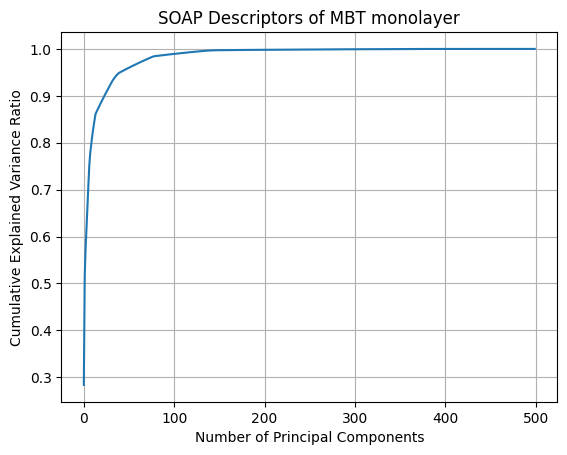

In [6]:
plot_PCA_variance(soap_desc_combined,500) # max we can go to 5240

In [7]:
def perform_pca(soap_desc, optimal_components):
    pca = PCA(n_components = optimal_components)
    soap_pca = pca.fit_transform(soap_desc)
    return soap_pca

optimized_pca_combined = perform_pca(soap_desc_combined, 256)
scaler = StandardScaler()
X = scaler.fit_transform(optimized_pca_combined)
latent_size = 64
input_dim = X.shape[1]

In [8]:
# Load labelled data
monolayer_MBT_DFT_data = pd.read_csv('id_props_240_labelled_data_MBT.csv')
y = monolayer_MBT_DFT_data[['Ef_per_cell', 'Mu_per_cell']]

nan_matrix = np.full((X.shape[0] - y.values.shape[0], y.values.shape[1]), np.nan)
y_combined = np.vstack((y.values, nan_matrix))
print(y_combined.shape)

(5240, 2)


In [9]:
print(y_combined)

[[-1.39368776  2.2775    ]
 [-1.8066236   2.2795    ]
 [-1.04476075  2.2615    ]
 ...
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]]


In [10]:
# # Define a custom loss function
# def custom_loss(y_true, y_pred):
#     batch_size = tf.shape(y_true)[0]
#     mask_tensor = tf.slice(mask, [0], [batch_size])
    
#     y_true_masked = tf.boolean_mask(y_true, mask_tensor)
#     y_pred_masked = tf.boolean_mask(y_pred, mask_tensor)
    
#     mse = tf.keras.losses.MeanSquaredError()
#     mse_masked_ef = mse(y_true_masked[:, 0], y_pred_masked[:, 0])
#     mse_masked_mu = mse(y_true_masked[:, 1], y_pred_masked[:, 1])
    
#     average_mse_masked = (mse_masked_ef + mse_masked_mu) / 2.0
#     return average_mse_masked

In [86]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_combined, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError

@tf.function
def custom_mse(y_true, y_pred):
    mask = ~tf.math.is_nan(y_true[:, 0])
    y_true = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_true)

    y_pred_true = tf.boolean_mask(y_pred, mask)
    y_true_true = tf.boolean_mask(y_true, mask)

    mse = tf.keras.losses.MeanSquaredError()(y_true_true, y_pred_true)
    
    # to get the average, we only want to divide by the number of labeled examples 
    num_labeled_examples = tf.reduce_sum(tf.cast(mask, tf.float32))
#    num_labeled_examples = tf.cast(num_labeled_examples, tf.float32)
    if num_labeled_examples < 1:
        avg_loss = 0.0
    else:
        avg_loss = tf.reduce_sum(mse) / num_labeled_examples
    
    return avg_loss

In [74]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

# Normalize data
X_train = np.nan_to_num(X_train)
X_val = np.nan_to_num(X_val)
X_test = np.nan_to_num(X_test)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / (std + 1e-8)
X_val = (X_val - mean) / (std + 1e-8)
X_test = (X_test - mean) / (std + 1e-8)

input_dim = X_train.shape[1]
latent_size = 64
target_dim = y_train.shape[1]
lr_autoencoder = 2.5e-3
lr_combined = 2.5e-3  # Reduced learning rate for combined model
epochs = 250
batch_size = 128

# Encoder
encoder_input = Input(shape=(input_dim,))
encoder_input_norm = BatchNormalization()(encoder_input)
encoder_hidden = Dense(input_dim, activation='selu', kernel_initializer='lecun_normal')(encoder_input_norm)
encoder_hidden = BatchNormalization()(encoder_hidden)
encoder_hidden = Dense(latent_size, activation='selu', kernel_initializer='lecun_normal')(encoder_hidden)
encoder_hidden = BatchNormalization()(encoder_hidden)
encoder_output = Dense(latent_size, activation='selu', kernel_initializer='lecun_normal')(encoder_hidden)

# Decoder
decoder_input = BatchNormalization()(encoder_output)
decoder_hidden = Dense(latent_size, activation='selu', kernel_initializer='lecun_normal')(decoder_input)
decoder_hidden = BatchNormalization()(decoder_hidden)
decoder_hidden = Dense(latent_size, activation='selu', kernel_initializer='lecun_normal')(decoder_hidden)
decoder_hidden = BatchNormalization()(decoder_hidden)
decoder_hidden = Dense(input_dim, activation='selu', kernel_initializer='lecun_normal')(decoder_hidden)
decoder_hidden = BatchNormalization()(decoder_hidden)
decoder_output = Dense(input_dim, activation='linear', kernel_initializer='lecun_normal')(decoder_hidden)

# Autoencoder
autoencoder = Model(inputs=encoder_input, outputs=decoder_output)
autoencoder.compile(optimizer=Adam(learning_rate=lr_autoencoder), loss=MeanSquaredError())

# FFNN
ffnn_input = BatchNormalization()(encoder_output)
ffnn_hidden = Dense(latent_size, activation='selu', kernel_initializer='lecun_normal')(ffnn_input)
ffnn_hidden = BatchNormalization()(ffnn_hidden)
ffnn_hidden = Dense(latent_size, activation='selu', kernel_initializer='lecun_normal')(ffnn_hidden)
ffnn_hidden = BatchNormalization()(ffnn_hidden)
ffnn_output = Dense(target_dim, activation='linear', kernel_initializer='lecun_normal')(ffnn_hidden)

# Combined Model
combined_output = [decoder_output, ffnn_output]
combined_model = Model(inputs=encoder_input, outputs=combined_output)
combined_model.compile(optimizer=Adam(learning_rate=lr_combined), loss=[MeanSquaredError(), custom_mse],
                       loss_weights=[1, 15], metrics=[MeanSquaredError(), custom_mse])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Training
#y_val_final = np.nan_to_num(y_val)
history_test = combined_model.fit(X_train, [X_train, y_train], validation_data=(X_val, [X_val, y_val]), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - dense_106_mean_squared_error: 1.3482 - dense_109_custom_mse: 0.0048 - loss: 1.4208 - val_dense_106_mean_squared_error: 1.2803 - val_dense_109_custom_mse: 0.0040 - val_loss: 1.3095
Epoch 2/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.9544 - dense_109_custom_mse: 0.0011 - loss: 0.9708 - val_dense_106_mean_squared_error: 1.0247 - val_dense_109_custom_mse: 0.0021 - val_loss: 1.0340
Epoch 3/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.9106 - dense_109_custom_mse: 6.2601e-04 - loss: 0.9200 - val_dense_106_mean_squared_error: 0.9494 - val_dense_109_custom_mse: 0.0013 - val_loss: 0.9501
Epoch 4/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.8702 - dense_109_custom_mse: 4.7585e-04 - loss: 0.8773 - val_dense_106_mean_squared_error: 0.9125 - val_dense_109_custom_mse: 0.0011 - val_loss: 0.9121
Epoch 5/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_

Epoch 31/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.4806 - dense_109_custom_mse: 1.2736e-04 - loss: 0.4826 - val_dense_106_mean_squared_error: 0.6106 - val_dense_109_custom_mse: 2.4089e-04 - val_loss: 0.6054
Epoch 32/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.4652 - dense_109_custom_mse: 9.8681e-05 - loss: 0.4665 - val_dense_106_mean_squared_error: 0.6065 - val_dense_109_custom_mse: 2.0509e-04 - val_loss: 0.6021
Epoch 33/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.4644 - dense_109_custom_mse: 1.1865e-04 - loss: 0.4661 - val_dense_106_mean_squared_error: 0.6039 - val_dense_109_custom_mse: 2.4024e-04 - val_loss: 0.5996
Epoch 34/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.4613 - dense_109_custom_mse: 1.0786e-04 - loss: 0.4628 - val_dense_106_mean_squared_error: 0.5930 - val_dense_109_custom_mse: 2.7152e-04 - val_loss: 0.5888
Epoch 35/250
25/25 ━━━━━━━━━━━━━

Epoch 61/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.3580 - dense_109_custom_mse: 1.0069e-04 - loss: 0.3595 - val_dense_106_mean_squared_error: 0.4892 - val_dense_109_custom_mse: 2.0446e-04 - val_loss: 0.4858
Epoch 62/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.3616 - dense_109_custom_mse: 1.2750e-04 - loss: 0.3635 - val_dense_106_mean_squared_error: 0.4865 - val_dense_109_custom_mse: 1.7619e-04 - val_loss: 0.4834
Epoch 63/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.3518 - dense_109_custom_mse: 6.5354e-05 - loss: 0.3527 - val_dense_106_mean_squared_error: 0.4815 - val_dense_109_custom_mse: 1.7424e-04 - val_loss: 0.4778
Epoch 64/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.3494 - dense_109_custom_mse: 9.9672e-05 - loss: 0.3508 - val_dense_106_mean_squared_error: 0.4801 - val_dense_109_custom_mse: 1.9642e-04 - val_loss: 0.4761
Epoch 65/250
25/25 ━━━━━━━━━━━━━

Epoch 91/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.3056 - dense_109_custom_mse: 5.7677e-05 - loss: 0.3065 - val_dense_106_mean_squared_error: 0.4238 - val_dense_109_custom_mse: 1.5185e-04 - val_loss: 0.4195
Epoch 92/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2955 - dense_109_custom_mse: 5.0226e-05 - loss: 0.2962 - val_dense_106_mean_squared_error: 0.4258 - val_dense_109_custom_mse: 1.3173e-04 - val_loss: 0.4217
Epoch 93/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.3006 - dense_109_custom_mse: 4.8640e-05 - loss: 0.3012 - val_dense_106_mean_squared_error: 0.4234 - val_dense_109_custom_mse: 1.4788e-04 - val_loss: 0.4187
Epoch 94/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2989 - dense_109_custom_mse: 5.1267e-05 - loss: 0.2996 - val_dense_106_mean_squared_error: 0.4160 - val_dense_109_custom_mse: 1.0889e-04 - val_loss: 0.4125
Epoch 95/250
25/25 ━━━━━━━━━━━━━

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2710 - dense_109_custom_mse: 4.1645e-05 - loss: 0.2716 - val_dense_106_mean_squared_error: 0.3748 - val_dense_109_custom_mse: 1.3625e-04 - val_loss: 0.3709
Epoch 121/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2701 - dense_109_custom_mse: 5.4117e-05 - loss: 0.2709 - val_dense_106_mean_squared_error: 0.3757 - val_dense_109_custom_mse: 1.4361e-04 - val_loss: 0.3721
Epoch 122/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.2621 - dense_109_custom_mse: 4.2271e-05 - loss: 0.2627 - val_dense_106_mean_squared_error: 0.3728 - val_dense_109_custom_mse: 1.3248e-04 - val_loss: 0.3694
Epoch 123/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2635 - dense_109_custom_mse: 4.2994e-05 - loss: 0.2641 - val_dense_106_mean_squared_error: 0.3704 - val_dense_109_custom_mse: 1.2535e-04 - val_loss: 0.3675
Epoch 124/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2444 - dense_109_custom_mse: 4.3820e-05 - loss: 0.2450 - val_dense_106_mean_squared_error: 0.3397 - val_dense_109_custom_mse: 1.5847e-04 - val_loss: 0.3377
Epoch 150/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2429 - dense_109_custom_mse: 4.6251e-05 - loss: 0.2436 - val_dense_106_mean_squared_error: 0.3387 - val_dense_109_custom_mse: 1.1897e-04 - val_loss: 0.3364
Epoch 151/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2436 - dense_109_custom_mse: 4.3991e-05 - loss: 0.2442 - val_dense_106_mean_squared_error: 0.3384 - val_dense_109_custom_mse: 1.5716e-04 - val_loss: 0.3366
Epoch 152/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2403 - dense_109_custom_mse: 3.7476e-05 - loss: 0.2408 - val_dense_106_mean_squared_error: 0.3354 - val_dense_109_custom_mse: 1.4901e-04 - val_loss: 0.3336
Epoch 153/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2234 - dense_109_custom_mse: 4.0823e-05 - loss: 0.2240 - val_dense_106_mean_squared_error: 0.3129 - val_dense_109_custom_mse: 1.3293e-04 - val_loss: 0.3107
Epoch 179/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.2244 - dense_109_custom_mse: 5.2715e-05 - loss: 0.2251 - val_dense_106_mean_squared_error: 0.3097 - val_dense_109_custom_mse: 1.8498e-04 - val_loss: 0.3085
Epoch 180/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2287 - dense_109_custom_mse: 5.9157e-05 - loss: 0.2296 - val_dense_106_mean_squared_error: 0.3096 - val_dense_109_custom_mse: 1.5317e-04 - val_loss: 0.3084
Epoch 181/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2230 - dense_109_custom_mse: 3.9822e-05 - loss: 0.2235 - val_dense_106_mean_squared_error: 0.3099 - val_dense_109_custom_mse: 1.4747e-04 - val_loss: 0.3090
Epoch 182/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2069 - dense_109_custom_mse: 3.9791e-05 - loss: 0.2074 - val_dense_106_mean_squared_error: 0.2851 - val_dense_109_custom_mse: 1.5360e-04 - val_loss: 0.2844
Epoch 208/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.2106 - dense_109_custom_mse: 4.3062e-05 - loss: 0.2112 - val_dense_106_mean_squared_error: 0.2819 - val_dense_109_custom_mse: 1.4854e-04 - val_loss: 0.2816
Epoch 209/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.2075 - dense_109_custom_mse: 3.4075e-05 - loss: 0.2080 - val_dense_106_mean_squared_error: 0.2796 - val_dense_109_custom_mse: 1.1297e-04 - val_loss: 0.2787
Epoch 210/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_106_mean_squared_error: 0.2107 - dense_109_custom_mse: 3.5703e-05 - loss: 0.2111 - val_dense_106_mean_squared_error: 0.2803 - val_dense_109_custom_mse: 1.1833e-04 - val_loss: 0.2794
Epoch 211/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.1949 - dense_109_custom_mse: 4.2977e-05 - loss: 0.1955 - val_dense_106_mean_squared_error: 0.2613 - val_dense_109_custom_mse: 1.0074e-04 - val_loss: 0.2612
Epoch 237/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.1917 - dense_109_custom_mse: 3.1372e-05 - loss: 0.1921 - val_dense_106_mean_squared_error: 0.2593 - val_dense_109_custom_mse: 1.0202e-04 - val_loss: 0.2590
Epoch 238/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dense_106_mean_squared_error: 0.1913 - dense_109_custom_mse: 2.4197e-05 - loss: 0.1917 - val_dense_106_mean_squared_error: 0.2579 - val_dense_109_custom_mse: 1.0918e-04 - val_loss: 0.2579
Epoch 239/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dense_106_mean_squared_error: 0.1946 - dense_109_custom_mse: 3.2561e-05 - loss: 0.1950 - val_dense_106_mean_squared_error: 0.2584 - val_dense_109_custom_mse: 1.1013e-04 - val_loss: 0.2583
Epoch 240/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0

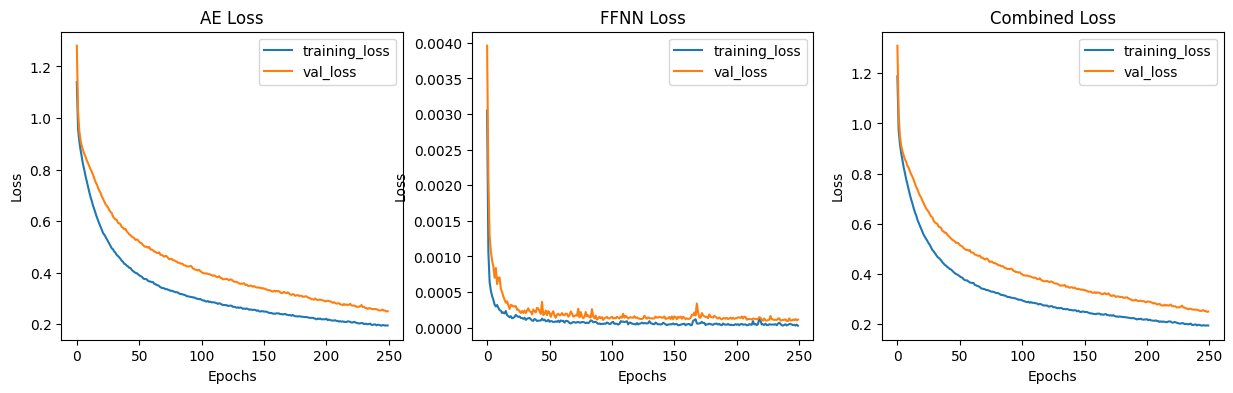

In [75]:
fig,ax = plt.subplots(1,3, figsize = (15,4))
title = ['AE Loss', 'FFNN Loss', 'Combined Loss']
keys = list(history_test.history.keys())
key_pairs = [(keys[i], keys[i+3]) for i in range(3)]

for i in range(3):
    ax[i].plot(history_test.history[key_pairs[i][0]], label='training_loss')
    ax[i].plot(history_test.history[key_pairs[i][1]], label='val_loss')

    ax[i].set_title(title[i])
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
#plt.savefig("loss_figures.png", dpi=300)

In [76]:
import numpy as np
from sklearn import metrics

# Predictions
pred_train = combined_model.predict(X_train)
pred_val = combined_model.predict(X_val)
pred_test = combined_model.predict(X_test)

# Ensure predictions do not contain NaNs
pred_train = [np.nan_to_num(pred) for pred in pred_train]
pred_val = [np.nan_to_num(pred) for pred in pred_val]
pred_test = [np.nan_to_num(pred) for pred in pred_test]

# Ensure y values do not contain NaNs
y_train = np.nan_to_num(y_train)
y_val = np.nan_to_num(y_val)
y_test = np.nan_to_num(y_test)

# Masks
mask_train_labeled = ~np.equal(y_train, 0).any(axis=1)
mask_val_labeled = ~np.equal(y_val, 0).any(axis=1)
mask_test_labeled = ~np.equal(y_test, 0).any(axis=1)

# Compute evaluation metrics for the labeled training data
r2_train_ef = metrics.r2_score(y_train[mask_train_labeled][:, 0], pred_train[1][mask_train_labeled][:, 0])
r2_train_mu = metrics.r2_score(y_train[mask_train_labeled][:, 1], pred_train[1][mask_train_labeled][:, 1])

mae_train_ef = metrics.mean_absolute_error(y_train[mask_train_labeled][:, 0], pred_train[1][mask_train_labeled][:, 0])
mae_train_mu = metrics.mean_absolute_error(y_train[mask_train_labeled][:, 1], pred_train[1][mask_train_labeled][:, 1])

# Compute evaluation metrics for the labeled validation data
r2_val_ef = metrics.r2_score(y_val[mask_val_labeled][:, 0], pred_val[1][mask_val_labeled][:, 0])
r2_val_mu = metrics.r2_score(y_val[mask_val_labeled][:, 1], pred_val[1][mask_val_labeled][:, 1])

mae_val_ef = metrics.mean_absolute_error(y_val[mask_val_labeled][:, 0], pred_val[1][mask_val_labeled][:, 0])
mae_val_mu = metrics.mean_absolute_error(y_val[mask_val_labeled][:, 1], pred_val[1][mask_val_labeled][:, 1])

# Compute evaluation metrics for the labeled test data
r2_test_ef = metrics.r2_score(y_test[mask_test_labeled][:, 0], pred_test[1][mask_test_labeled][:, 0])
r2_test_mu = metrics.r2_score(y_test[mask_test_labeled][:, 1], pred_test[1][mask_test_labeled][:, 1])

mae_test_ef = metrics.mean_absolute_error(y_test[mask_test_labeled][:, 0], pred_test[1][mask_test_labeled][:, 0])
mae_test_mu = metrics.mean_absolute_error(y_test[mask_test_labeled][:, 1], pred_test[1][mask_test_labeled][:, 1])

width = 10
print(f'{"Properties":>{width+1}} {"R2(Train)":>{width+1}} {"R2(Val)":>{width-1}} {"R2(Test)":>{width}} {"MAE(Train)":>{width+2}} {"MAE(Val)":>{width}} {"MAE(Test)":>{width}}')
print('='*80)
print(f'{"Ef":>{width}} {r2_train_ef:>{width}.3f} {r2_val_ef:>{width}.3f} {r2_test_ef:>{width}.3f} {mae_train_ef:>{width}.3f} {mae_val_ef:>{width}.3f} {mae_test_ef:>{width}.3f}')
print(f'{"Mu":>{width}} {r2_train_mu:>{width}.3f} {r2_val_mu:>{width}.3f} {r2_test_mu:>{width}.3f} {mae_train_mu:>{width}.3f} {mae_val_mu:>{width}.3f} {mae_test_mu:>{width}.3f}')


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 Properties   R2(Train)   R2(Val)   R2(Test)   MAE(Train)   MAE(Val)  MAE(Test)
        Ef      0.974      0.683      0.790      0.141      0.394      0.411
        Mu      0.941      0.687      0.752      0.157      0.333      0.286


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


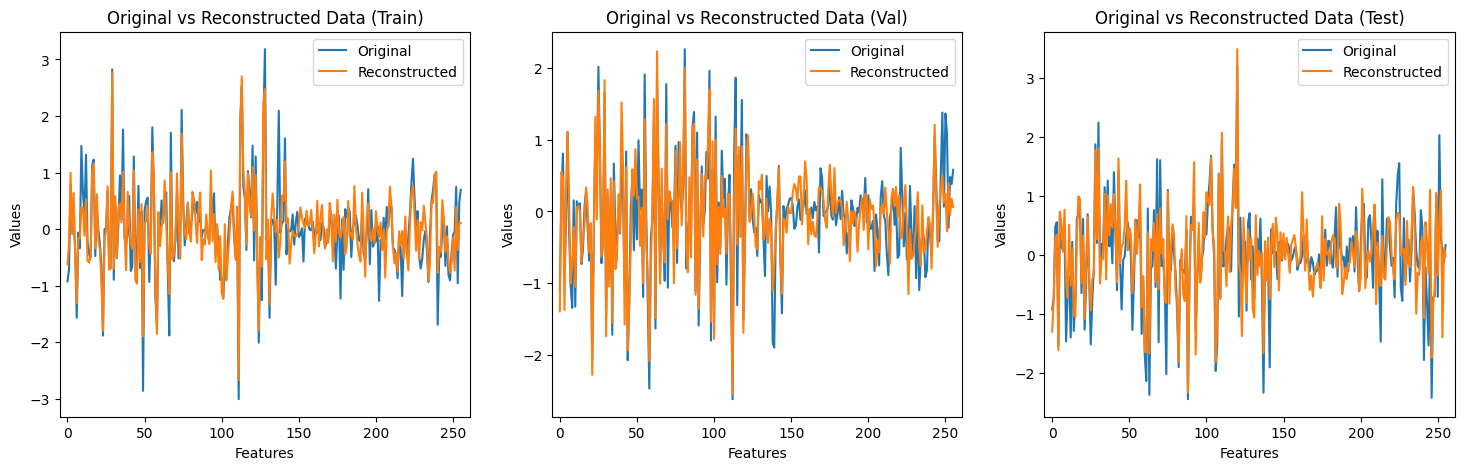

<Figure size 640x480 with 0 Axes>

In [77]:
reconstructed_X_train = autoencoder.predict(X_train)
reconstructed_X_val = autoencoder.predict(X_val)
reconstructed_X_test = autoencoder.predict(X_test)

sample_idx_train = X_train[0]
sample_idx_val = X_val[0]
sample_idx_test = X_test[0]

fig, ax = plt.subplots(1,3, figsize = (18,5))

ax[0].plot(X_train[0], label = 'Original')
ax[1].plot(X_val[0], label = 'Original')
ax[2].plot(X_test[0], label = 'Original')

ax[0].plot(reconstructed_X_train[0], label = 'Reconstructed')
ax[1].plot(reconstructed_X_val[0], label = 'Reconstructed')
ax[2].plot(reconstructed_X_test[0], label = 'Reconstructed')

ax[0].set_xlabel('Features')
ax[0].set_ylabel('Values')

ax[1].set_xlabel('Features')
ax[1].set_ylabel('Values')

ax[2].set_xlabel('Features')
ax[2].set_ylabel('Values')

ax[0].set_title('Original vs Reconstructed Data (Train)')
ax[1].set_title('Original vs Reconstructed Data (Val)')
ax[2].set_title('Original vs Reconstructed Data (Test)')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_xlim([-5, X.shape[1]+5])
ax[1].set_xlim([-5, X.shape[1]+5])
ax[2].set_xlim([-5, X.shape[1]+5])

plt.show()

#plt.savefig("reconstruction_figure.png", dpi=300)

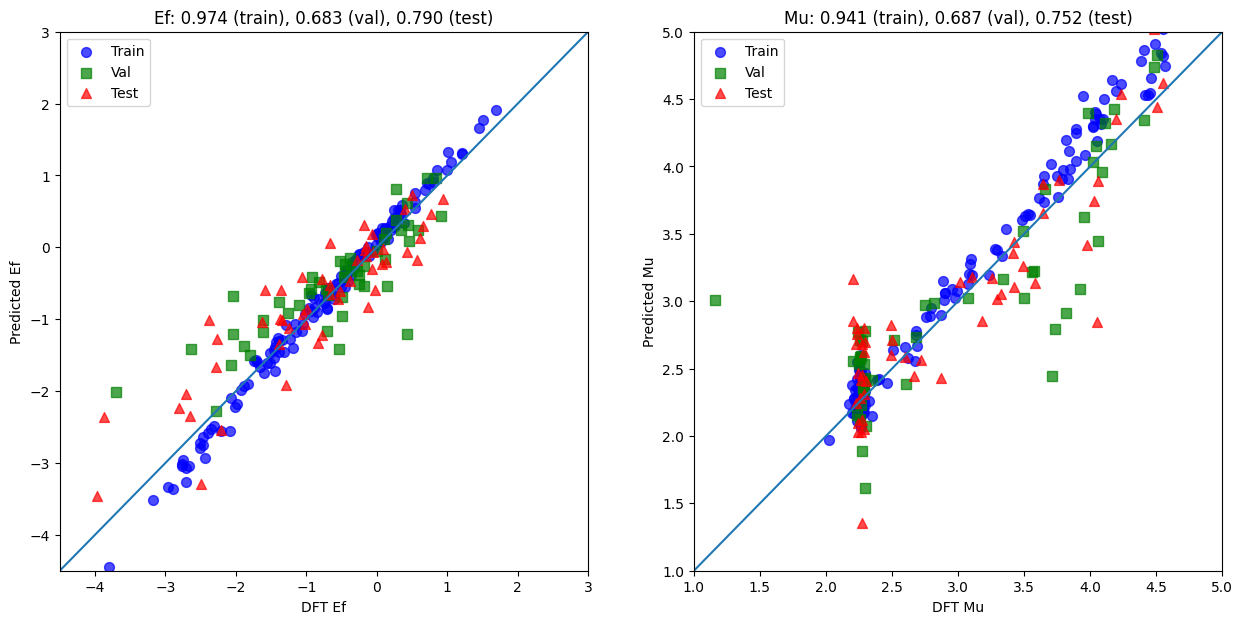

<Figure size 640x480 with 0 Axes>

In [78]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (15,7))
ax1.scatter(y_train[mask_train_labeled][:, 0], pred_train[1][mask_train_labeled][:, 0], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
ax1.scatter(y_val[mask_val_labeled][:, 0], pred_val[1][mask_val_labeled][:, 0], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax1.scatter(y_test[mask_test_labeled][:, 0], pred_test[1][mask_test_labeled][:, 0], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax1.plot([-4.5, 3], [-4.5, 3])

ax2.scatter(y_train[mask_train_labeled][:, 1], pred_train[1][mask_train_labeled][:, 1], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
ax2.scatter(y_val[mask_val_labeled][:, 1], pred_val[1][mask_val_labeled][:, 1], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax2.scatter(y_test[mask_test_labeled][:, 1], pred_test[1][mask_test_labeled][:, 1], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax2.plot([0, 5], [0, 5])

ax1.set_title('Ef: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(r2_train_ef,r2_val_ef, r2_test_ef))
ax2.set_title('Mu: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(r2_train_mu,r2_val_mu, r2_test_mu))

ax1.set_xlabel('DFT Ef')
ax1.set_ylabel('Predicted Ef')

ax2.set_xlabel('DFT Mu')
ax2.set_ylabel('Predicted Mu')

ax1.set_xlim([-4.5, 3])
ax1.set_ylim([-4.5, 3])

ax2.set_xlim([1, 5])
ax2.set_ylim([1, 5])

ax1.legend()
ax2.legend()

plt.show()

#plt.savefig("r2s.png", dpi=300)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


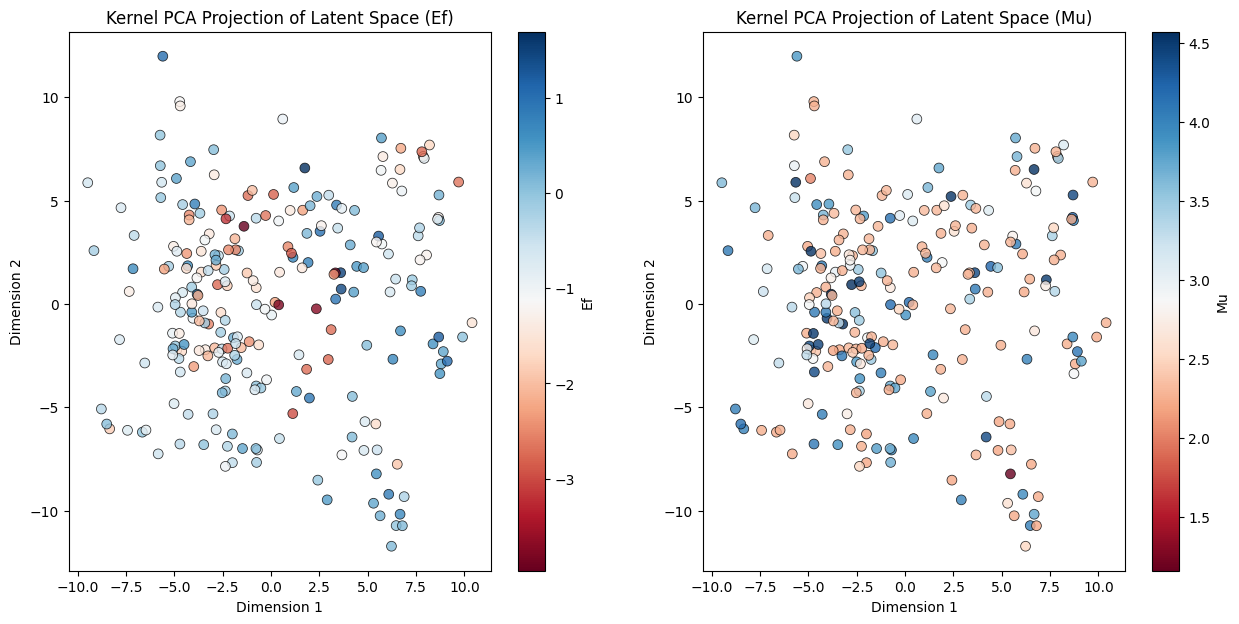

<Figure size 640x480 with 0 Axes>

In [79]:
# Extract latent representations
encoder_model = Model(inputs = encoder_input, outputs = encoder_output)
latent_X = encoder_model.predict(X[:240,:])

# Apply Kernel PCA
kpca = KernelPCA(n_components=2, kernel='linear', gamma=None, fit_inverse_transform=True, alpha=1.0, n_jobs=-1)
kpca_embeddings = kpca.fit_transform(latent_X)

# Create a DataFrame for Seaborn
kpca_df = pd.DataFrame(data={'Dimension 1': kpca_embeddings[:, 0],
                             'Dimension 2': kpca_embeddings[:, 1],
                             'Ef': y['Ef_per_cell'],
                             'Mu': y['Mu_per_cell']})

# Visualize the projected latent space using Seaborn
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
scatter_ef = sns.scatterplot(ax=ax[0], data=kpca_df, x='Dimension 1', y='Dimension 2', hue='Ef', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)
scatter_mu = sns.scatterplot(ax=ax[1], data=kpca_df, x='Dimension 1', y='Dimension 2', hue='Mu', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)

norm_ef = Normalize(vmin=kpca_df['Ef'].min(), vmax=kpca_df['Ef'].max())
norm_mu = Normalize(vmin=kpca_df['Mu'].min(), vmax=kpca_df['Mu'].max())

sm_ef = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_ef)
sm_mu = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_mu)

sm_ef.set_array([])
sm_mu.set_array([])

cbar_ef = fig.colorbar(sm_ef, ax=ax[0])
cbar_mu = fig.colorbar(sm_mu, ax=ax[1])

cbar_ef.set_label('Ef')
cbar_mu.set_label('Mu')

ax[0].set_title('Kernel PCA Projection of Latent Space (Ef)')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')

ax[1].set_title('Kernel PCA Projection of Latent Space (Mu)')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')

plt.show()

#plt.savefig("pca_deconstructions.png", dpi=300)

In [49]:
# !pip install optuna
# !pip install nbformat
import optuna
import optuna.importance
from optuna.visualization import plot_pareto_front, plot_param_importances, plot_parallel_coordinate, plot_intermediate_values

C:\Users\Romakanta\Desktop\vENVs\vSOAP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [100]:
def optuna_HP(trial):
    try:
    
        # Hyperparameters to tune
        input_dim = X_train.shape[1]
        target_dim = y_train.shape[1]
        epochs = 250
        batch_size = 128
        ae_hidden_dim1 = trial.suggest_int('ae_hidden_dim1', 120, input_dim)
        ae_hidden_dim2 = trial.suggest_int('ae_hidden_dim2', 50, ae_hidden_dim1)
        latent_size = trial.suggest_int('latent_size', 50, input_dim)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3)
        ffnn_hid_dim1 = trial.suggest_int('ffnn_hid_dim1', 20, latent_size)
        activation_funcn = trial.suggest_categorical('activation_funcn', ['elu', 'relu', 'selu'])

        # Optimizer
        optimizer = Adam(learning_rate=learning_rate)

        # Model architecture

        # Encoder
        encoder_input = Input(shape=(input_dim,))
        encoder_input_norm = BatchNormalization()(encoder_input)
        encoder_hidden = Dense(ae_hidden_dim1, activation=activation_funcn, kernel_initializer='lecun_normal')(encoder_input_norm)
        encoder_hidden = BatchNormalization()(encoder_hidden)
        encoder_hidden = Dense(ae_hidden_dim2, activation=activation_funcn, kernel_initializer='lecun_normal')(encoder_hidden)
        encoder_hidden = BatchNormalization()(encoder_hidden)
        encoder_output = Dense(latent_size, activation=activation_funcn, kernel_initializer='lecun_normal')(encoder_hidden)

        # Decoder
        decoder_input = BatchNormalization()(encoder_output)
        decoder_hidden = Dense(latent_size, activation=activation_funcn, kernel_initializer='lecun_normal')(decoder_input)
        decoder_hidden = BatchNormalization()(decoder_hidden)
        decoder_hidden = Dense(ae_hidden_dim2, activation=activation_funcn, kernel_initializer='lecun_normal')(decoder_hidden)
        decoder_hidden = BatchNormalization()(decoder_hidden)
        decoder_hidden = Dense(ae_hidden_dim1, activation=activation_funcn, kernel_initializer='lecun_normal')(decoder_hidden)
        decoder_hidden = BatchNormalization()(decoder_hidden)
        decoder_output = Dense(input_dim, activation='linear', kernel_initializer='lecun_normal')(decoder_hidden)

        # Autoencoder
        autoencoder = Model(inputs=encoder_input, outputs=decoder_output)
        autoencoder.compile(optimizer=optimizer, loss=MeanSquaredError())

        # FFNN
        ffnn_input = BatchNormalization()(encoder_output)
        ffnn_hidden = Dense(latent_size, activation=activation_funcn, kernel_initializer='lecun_normal')(ffnn_input)
        ffnn_hidden = BatchNormalization()(ffnn_hidden)
        ffnn_hidden = Dense(ffnn_hid_dim1, activation=activation_funcn, kernel_initializer='lecun_normal')(ffnn_hidden)
        ffnn_hidden = BatchNormalization()(ffnn_hidden)
        ffnn_output = Dense(target_dim, activation='linear', kernel_initializer='lecun_normal')(ffnn_hidden)

        # Combined Model
        combined_output = [decoder_output, ffnn_output]
        combined_model = Model(inputs=encoder_input, outputs=combined_output)
        combined_model.compile(optimizer=optimizer, loss=[MeanSquaredError(), custom_mse],
                               loss_weights=[1, 15], metrics=[MeanSquaredError(), custom_mse])

        # Early stopping to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Training
#        y_val_final = np.nan_to_num(y_val)
        history_HP_run = combined_model.fit(X_train, [X_train, y_train], validation_data=(X_val, [X_val, y_val]), 
                                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=0)

        # Predictions
        pred_val = combined_model.predict(X_val)
        pred_val = [np.nan_to_num(pred) for pred in pred_val]
        y_val_final = np.nan_to_num(y_val)
        mask_val_labeled = ~np.equal(y_val_final, 0).any(axis=1)

        # Compute evaluation metrics for the labeled validation data
        r2_val_ef = metrics.r2_score(y_val_final[mask_val_labeled][:, 0], pred_val[1][mask_val_labeled][:, 0])
        r2_val_mu = metrics.r2_score(y_val_final[mask_val_labeled][:, 1], pred_val[1][mask_val_labeled][:, 1])

        return r2_val_ef,r2_val_mu    

    except ValueError as e:
        print(f"Trial failed due to error: {e}")
        return -float('inf'), -float('inf')

In [101]:
# Create and optimize the study
study = optuna.create_study(directions = ['maximize','maximize'])
study.optimize(optuna_HP, n_trials=200)

[I 2024-06-16 18:52:20,523] A new study created in memory with name: no-name-6240dcb3-a587-47d8-95cc-7bb1f8b26091


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 18:53:00,631] Trial 0 finished with values: [0.8465513803334175, 0.7040424970416095] and parameters: {'ae_hidden_dim1': 129, 'ae_hidden_dim2': 110, 'latent_size': 115, 'learning_rate': 0.0030283483614553745, 'ffnn_hid_dim1': 108, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 18:53:53,113] Trial 1 finished with values: [0.7477506326465262, 0.8002195247296279] and parameters: {'ae_hidden_dim1': 232, 'ae_hidden_dim2': 189, 'latent_size': 231, 'learning_rate': 0.0017111877196485262, 'ffnn_hid_dim1': 151, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 18:54:34,528] Trial 2 finished with values: [0.8235116398812828, 0.7927145925898222] and parameters: {'ae_hidden_dim1': 136, 'ae_hidden_dim2': 77, 'latent_size': 69, 'learning_rate': 0.004953053125434455, 'ffnn_hid_dim1': 56, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 18:55:26,259] Trial 3 finished with values: [0.807869299521913, 0.8436332882839175] and parameters: {'ae_hidden_dim1': 209, 'ae_hidden_dim2': 80, 'latent_size': 147, 'learning_rate': 0.0025599026364635717, 'ffnn_hid_dim1': 38, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-06-16 18:56:22,844] Trial 4 finished with values: [0.7013600255546938, 0.5577149587200385] and parameters: {'ae_hidden_dim1': 167, 'ae_hidden_dim2': 95, 'latent_size': 222, 'learning_rate': 0.001251491612237021, 'ffnn_hid_dim1': 129, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 18:57:04,949] Trial 5 finished with values: [0.8155029597470123, 0.5657340097414867] and parameters: {'ae_hidden_dim1': 175, 'ae_hidden_dim2': 75, 'latent_size': 53, 'learning_rate': 0.00485653556438057, 'ffnn_hid_dim1': 31, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 18:57:59,054] Trial 6 finished with values: [0.7408819008405525, 0.6817924097577672] and parameters: {'ae_hidden_dim1': 174, 'ae_hidden_dim2': 141, 'latent_size': 82, 'learning_rate': 0.0019042030079077011, 'ffnn_hid_dim1': 46, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 18:58:57,393] Trial 7 finished with values: [0.8482385149292518, 0.5808996285476027] and parameters: {'ae_hidden_dim1': 140, 'ae_hidden_dim2': 124, 'latent_size': 93, 'learning_rate': 0.0007416952146655174, 'ffnn_hid_dim1': 89, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 18:59:19,391] Trial 8 finished with values: [0.6472607476533382, 0.3116778165606082] and parameters: {'ae_hidden_dim1': 188, 'ae_hidden_dim2': 50, 'latent_size': 90, 'learning_rate': 0.0010790503614357776, 'ffnn_hid_dim1': 37, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 18:59:38,672] Trial 9 finished with values: [0.7798377146307692, 0.4438935124410083] and parameters: {'ae_hidden_dim1': 128, 'ae_hidden_dim2': 78, 'latent_size': 214, 'learning_rate': 0.002335989582396391, 'ffnn_hid_dim1': 210, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:00:33,307] Trial 10 finished with values: [0.8597774374675312, 0.8046559971365101] and parameters: {'ae_hidden_dim1': 181, 'ae_hidden_dim2': 136, 'latent_size': 248, 'learning_rate': 0.0022784260768035406, 'ffnn_hid_dim1': 115, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:01:28,498] Trial 11 finished with values: [0.8240503649825335, 0.8346147870457548] and parameters: {'ae_hidden_dim1': 222, 'ae_hidden_dim2': 111, 'latent_size': 63, 'learning_rate': 0.004505490436062231, 'ffnn_hid_dim1': 56, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:02:09,974] Trial 12 finished with values: [0.8387272442575033, 0.8500823850503181] and parameters: {'ae_hidden_dim1': 249, 'ae_hidden_dim2': 79, 'latent_size': 211, 'learning_rate': 0.004049151301270821, 'ffnn_hid_dim1': 61, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:03:09,392] Trial 13 finished with values: [0.757501634824426, 0.7510517708016066] and parameters: {'ae_hidden_dim1': 231, 'ae_hidden_dim2': 74, 'latent_size': 238, 'learning_rate': 0.001814996936025038, 'ffnn_hid_dim1': 190, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:03:38,563] Trial 14 finished with values: [0.8010808378663811, 0.7596696194927307] and parameters: {'ae_hidden_dim1': 214, 'ae_hidden_dim2': 141, 'latent_size': 210, 'learning_rate': 0.0041379860554999265, 'ffnn_hid_dim1': 181, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:04:26,857] Trial 15 finished with values: [0.7544878460758185, 0.8409702734855522] and parameters: {'ae_hidden_dim1': 220, 'ae_hidden_dim2': 62, 'latent_size': 168, 'learning_rate': 0.0035168148329262202, 'ffnn_hid_dim1': 43, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:05:00,912] Trial 16 finished with values: [0.5539013419960797, 0.42130427404261506] and parameters: {'ae_hidden_dim1': 130, 'ae_hidden_dim2': 60, 'latent_size': 226, 'learning_rate': 0.0032070148254355916, 'ffnn_hid_dim1': 207, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:06:02,672] Trial 17 finished with values: [0.6059363444560726, 0.46040967786312637] and parameters: {'ae_hidden_dim1': 130, 'ae_hidden_dim2': 110, 'latent_size': 173, 'learning_rate': 0.0002622731435871979, 'ffnn_hid_dim1': 114, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:07:04,775] Trial 18 finished with values: [0.8093708468214182, 0.8267367601347311] and parameters: {'ae_hidden_dim1': 228, 'ae_hidden_dim2': 192, 'latent_size': 63, 'learning_rate': 0.0030464082947155953, 'ffnn_hid_dim1': 35, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:08:07,905] Trial 19 finished with values: [0.7338094197853128, 0.6530876027743859] and parameters: {'ae_hidden_dim1': 253, 'ae_hidden_dim2': 187, 'latent_size': 52, 'learning_rate': 0.0011272575289966072, 'ffnn_hid_dim1': 45, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:08:51,138] Trial 20 finished with values: [0.8557667206493285, 0.7601683336163699] and parameters: {'ae_hidden_dim1': 196, 'ae_hidden_dim2': 96, 'latent_size': 93, 'learning_rate': 0.0033595896813513075, 'ffnn_hid_dim1': 20, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:09:30,284] Trial 21 finished with values: [0.7737422302474084, 0.677094665639431] and parameters: {'ae_hidden_dim1': 153, 'ae_hidden_dim2': 132, 'latent_size': 200, 'learning_rate': 0.0028834587980804184, 'ffnn_hid_dim1': 137, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:09:52,951] Trial 22 finished with values: [0.31339637092993256, 0.1314648101852074] and parameters: {'ae_hidden_dim1': 130, 'ae_hidden_dim2': 83, 'latent_size': 221, 'learning_rate': 0.0017272065007954624, 'ffnn_hid_dim1': 157, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:10:56,602] Trial 23 finished with values: [0.7424552880177688, 0.7241648957311778] and parameters: {'ae_hidden_dim1': 235, 'ae_hidden_dim2': 127, 'latent_size': 184, 'learning_rate': 0.00045259418507911887, 'ffnn_hid_dim1': 70, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:11:55,887] Trial 24 finished with values: [0.8497464542267943, 0.7924248810603978] and parameters: {'ae_hidden_dim1': 231, 'ae_hidden_dim2': 114, 'latent_size': 152, 'learning_rate': 0.004007714106872981, 'ffnn_hid_dim1': 73, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:12:16,434] Trial 25 finished with values: [0.6765911004967413, 0.6290049478733346] and parameters: {'ae_hidden_dim1': 211, 'ae_hidden_dim2': 137, 'latent_size': 156, 'learning_rate': 0.0029999091651870817, 'ffnn_hid_dim1': 37, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:13:02,952] Trial 26 finished with values: [0.8421406435229208, 0.7898224205109565] and parameters: {'ae_hidden_dim1': 173, 'ae_hidden_dim2': 122, 'latent_size': 79, 'learning_rate': 0.0025102843033353315, 'ffnn_hid_dim1': 55, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:14:34,662] Trial 27 finished with values: [0.794384121690815, 0.7718050389172398] and parameters: {'ae_hidden_dim1': 237, 'ae_hidden_dim2': 176, 'latent_size': 142, 'learning_rate': 0.0020757626377665385, 'ffnn_hid_dim1': 102, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:15:29,529] Trial 28 finished with values: [0.7268667888500977, 0.5508952518783319] and parameters: {'ae_hidden_dim1': 163, 'ae_hidden_dim2': 76, 'latent_size': 123, 'learning_rate': 0.0019994738329577964, 'ffnn_hid_dim1': 101, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:15:55,284] Trial 29 finished with values: [0.7807647707592046, 0.6383015017443512] and parameters: {'ae_hidden_dim1': 209, 'ae_hidden_dim2': 207, 'latent_size': 180, 'learning_rate': 0.004552885163566375, 'ffnn_hid_dim1': 48, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:17:13,249] Trial 30 finished with values: [0.7855336263405538, 0.7496306083956394] and parameters: {'ae_hidden_dim1': 195, 'ae_hidden_dim2': 88, 'latent_size': 177, 'learning_rate': 0.0014484844167360995, 'ffnn_hid_dim1': 151, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:18:28,581] Trial 31 finished with values: [0.7619194613940379, 0.7601550551043715] and parameters: {'ae_hidden_dim1': 139, 'ae_hidden_dim2': 75, 'latent_size': 249, 'learning_rate': 0.0008641017084236419, 'ffnn_hid_dim1': 53, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:19:24,632] Trial 32 finished with values: [0.8051598602335667, 0.7791376250028809] and parameters: {'ae_hidden_dim1': 224, 'ae_hidden_dim2': 128, 'latent_size': 87, 'learning_rate': 0.004929016946985177, 'ffnn_hid_dim1': 80, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:20:03,805] Trial 33 finished with values: [0.744643617106148, 0.5380527746089656] and parameters: {'ae_hidden_dim1': 167, 'ae_hidden_dim2': 153, 'latent_size': 209, 'learning_rate': 0.002900814750927427, 'ffnn_hid_dim1': 172, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:20:54,039] Trial 34 finished with values: [0.77803550884176, 0.7548866113526649] and parameters: {'ae_hidden_dim1': 167, 'ae_hidden_dim2': 109, 'latent_size': 131, 'learning_rate': 0.0026463471159444826, 'ffnn_hid_dim1': 25, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:22:13,925] Trial 35 finished with values: [0.8043484455122674, 0.7179895557576891] and parameters: {'ae_hidden_dim1': 180, 'ae_hidden_dim2': 113, 'latent_size': 214, 'learning_rate': 0.0026723116417972834, 'ffnn_hid_dim1': 160, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:23:30,732] Trial 36 finished with values: [0.8647654909532672, 0.6144467806863081] and parameters: {'ae_hidden_dim1': 254, 'ae_hidden_dim2': 84, 'latent_size': 181, 'learning_rate': 0.0008583878027048145, 'ffnn_hid_dim1': 172, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:24:15,582] Trial 37 finished with values: [0.7452483374579789, 0.6157874353912345] and parameters: {'ae_hidden_dim1': 209, 'ae_hidden_dim2': 147, 'latent_size': 231, 'learning_rate': 0.0021946821220189933, 'ffnn_hid_dim1': 212, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:25:08,931] Trial 38 finished with values: [0.7816315739028027, 0.784081794619878] and parameters: {'ae_hidden_dim1': 134, 'ae_hidden_dim2': 56, 'latent_size': 101, 'learning_rate': 0.0023951491679355405, 'ffnn_hid_dim1': 25, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:26:38,727] Trial 39 finished with values: [0.8422777960160656, 0.862723740736688] and parameters: {'ae_hidden_dim1': 235, 'ae_hidden_dim2': 156, 'latent_size': 255, 'learning_rate': 0.004143408465482456, 'ffnn_hid_dim1': 171, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:28:20,902] Trial 40 finished with values: [0.7617262927370207, 0.6869132802741088] and parameters: {'ae_hidden_dim1': 238, 'ae_hidden_dim2': 58, 'latent_size': 104, 'learning_rate': 0.0010187678733667468, 'ffnn_hid_dim1': 66, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:29:57,857] Trial 41 finished with values: [0.8227403044484611, 0.6269726273770154] and parameters: {'ae_hidden_dim1': 126, 'ae_hidden_dim2': 61, 'latent_size': 137, 'learning_rate': 0.0009689708129818576, 'ffnn_hid_dim1': 91, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:30:59,040] Trial 42 finished with values: [0.8040542943618226, 0.7423678687740434] and parameters: {'ae_hidden_dim1': 210, 'ae_hidden_dim2': 86, 'latent_size': 223, 'learning_rate': 0.0028166041129216446, 'ffnn_hid_dim1': 60, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:31:44,529] Trial 43 finished with values: [0.7797200888752244, 0.7076463892129049] and parameters: {'ae_hidden_dim1': 203, 'ae_hidden_dim2': 96, 'latent_size': 109, 'learning_rate': 0.003279642818328047, 'ffnn_hid_dim1': 95, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:33:16,994] Trial 44 finished with values: [0.6070251303174312, 0.26109698116709446] and parameters: {'ae_hidden_dim1': 130, 'ae_hidden_dim2': 110, 'latent_size': 111, 'learning_rate': 0.0001226007547881151, 'ffnn_hid_dim1': 71, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:33:53,778] Trial 45 finished with values: [0.635920161726326, 0.485133659868642] and parameters: {'ae_hidden_dim1': 224, 'ae_hidden_dim2': 106, 'latent_size': 127, 'learning_rate': 0.0015316582774241507, 'ffnn_hid_dim1': 76, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:34:39,502] Trial 46 finished with values: [0.8821331105340556, 0.7756965536164225] and parameters: {'ae_hidden_dim1': 123, 'ae_hidden_dim2': 58, 'latent_size': 69, 'learning_rate': 0.002813026769617995, 'ffnn_hid_dim1': 68, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:35:28,999] Trial 47 finished with values: [0.8548178478805415, 0.6032756266118543] and parameters: {'ae_hidden_dim1': 135, 'ae_hidden_dim2': 76, 'latent_size': 220, 'learning_rate': 0.004704907173554527, 'ffnn_hid_dim1': 49, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:36:41,774] Trial 48 finished with values: [0.7420260235373809, 0.5533952512368455] and parameters: {'ae_hidden_dim1': 186, 'ae_hidden_dim2': 158, 'latent_size': 140, 'learning_rate': 0.0006881717822075705, 'ffnn_hid_dim1': 85, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:37:29,704] Trial 49 finished with values: [0.6016916849225683, 0.4073844241075857] and parameters: {'ae_hidden_dim1': 212, 'ae_hidden_dim2': 134, 'latent_size': 171, 'learning_rate': 0.00043458278237531295, 'ffnn_hid_dim1': 86, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 19:38:23,952] Trial 50 finished with values: [0.782163342191541, 0.5837428773474507] and parameters: {'ae_hidden_dim1': 210, 'ae_hidden_dim2': 196, 'latent_size': 193, 'learning_rate': 0.0028166041129216446, 'ffnn_hid_dim1': 150, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:39:36,419] Trial 51 finished with values: [0.8734262835604957, 0.7819471660162021] and parameters: {'ae_hidden_dim1': 123, 'ae_hidden_dim2': 84, 'latent_size': 90, 'learning_rate': 0.0018305760789444144, 'ffnn_hid_dim1': 30, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:40:58,167] Trial 52 finished with values: [0.8760530856474971, 0.8458054662399348] and parameters: {'ae_hidden_dim1': 136, 'ae_hidden_dim2': 126, 'latent_size': 69, 'learning_rate': 0.002546592401802393, 'ffnn_hid_dim1': 39, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:42:28,705] Trial 53 finished with values: [0.8110047657336201, 0.7481430149701356] and parameters: {'ae_hidden_dim1': 238, 'ae_hidden_dim2': 99, 'latent_size': 137, 'learning_rate': 0.0021946821220189933, 'ffnn_hid_dim1': 39, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-06-16 19:43:36,654] Trial 54 finished with values: [0.46977152413847956, -0.09104907558199882] and parameters: {'ae_hidden_dim1': 136, 'ae_hidden_dim2': 88, 'latent_size': 92, 'learning_rate': 0.00010082547583760446, 'ffnn_hid_dim1': 34, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 19:44:33,872] Trial 55 finished with values: [0.6898609537507829, 0.47631780778487964] and parameters: {'ae_hidden_dim1': 231, 'ae_hidden_dim2': 72, 'latent_size': 247, 'learning_rate': 0.0033400860583641108, 'ffnn_hid_dim1': 105, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 19:46:39,466] Trial 56 finished with values: [0.8675510114322696, 0.8131024601408066] and parameters: {'ae_hidden_dim1': 134, 'ae_hidden_dim2': 125, 'latent_size': 209, 'learning_rate': 0.0023951491679355405, 'ffnn_hid_dim1': 118, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:47:44,615] Trial 57 finished with values: [0.7603318830859048, 0.7211901153153419] and parameters: {'ae_hidden_dim1': 135, 'ae_hidden_dim2': 126, 'latent_size': 168, 'learning_rate': 0.0016335854120299975, 'ffnn_hid_dim1': 97, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:48:40,206] Trial 58 finished with values: [0.7019584444458775, 0.6564810034622] and parameters: {'ae_hidden_dim1': 195, 'ae_hidden_dim2': 86, 'latent_size': 99, 'learning_rate': 0.0014484844167360995, 'ffnn_hid_dim1': 62, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 19:49:50,519] Trial 59 finished with values: [0.7400957793045568, 0.6392200468661532] and parameters: {'ae_hidden_dim1': 254, 'ae_hidden_dim2': 176, 'latent_size': 209, 'learning_rate': 0.004270592594444533, 'ffnn_hid_dim1': 166, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 19:51:44,210] Trial 60 finished with values: [0.8788225144589417, 0.7707678417169173] and parameters: {'ae_hidden_dim1': 176, 'ae_hidden_dim2': 79, 'latent_size': 205, 'learning_rate': 0.0011272575289966072, 'ffnn_hid_dim1': 191, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 19:52:46,300] Trial 61 finished with values: [0.8750667568444416, 0.769762233261603] and parameters: {'ae_hidden_dim1': 180, 'ae_hidden_dim2': 178, 'latent_size': 220, 'learning_rate': 0.004704907173554527, 'ffnn_hid_dim1': 51, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:54:20,129] Trial 62 finished with values: [0.8545850611790619, 0.7553748970150779] and parameters: {'ae_hidden_dim1': 167, 'ae_hidden_dim2': 72, 'latent_size': 168, 'learning_rate': 0.0019731527864473354, 'ffnn_hid_dim1': 97, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:55:34,693] Trial 63 finished with values: [0.8540787558648095, 0.5690406726553137] and parameters: {'ae_hidden_dim1': 231, 'ae_hidden_dim2': 125, 'latent_size': 107, 'learning_rate': 0.00481826432990731, 'ffnn_hid_dim1': 61, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:56:21,360] Trial 64 finished with values: [0.8515643660086, 0.7819276952529477] and parameters: {'ae_hidden_dim1': 138, 'ae_hidden_dim2': 109, 'latent_size': 93, 'learning_rate': 0.0033595896813513075, 'ffnn_hid_dim1': 30, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:57:48,128] Trial 65 finished with values: [0.8417240674335951, 0.7641659017262925] and parameters: {'ae_hidden_dim1': 173, 'ae_hidden_dim2': 127, 'latent_size': 248, 'learning_rate': 0.0021291345150262213, 'ffnn_hid_dim1': 240, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 19:58:58,226] Trial 66 finished with values: [0.8334077087128173, 0.6781627785019626] and parameters: {'ae_hidden_dim1': 224, 'ae_hidden_dim2': 116, 'latent_size': 127, 'learning_rate': 0.0015316582774241507, 'ffnn_hid_dim1': 69, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:00:10,468] Trial 67 finished with values: [0.8623170261474329, 0.7714895213202193] and parameters: {'ae_hidden_dim1': 134, 'ae_hidden_dim2': 70, 'latent_size': 69, 'learning_rate': 0.004953053125434455, 'ffnn_hid_dim1': 69, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 20:01:49,371] Trial 68 finished with values: [0.5250796743783179, 0.30175185467039445] and parameters: {'ae_hidden_dim1': 139, 'ae_hidden_dim2': 108, 'latent_size': 249, 'learning_rate': 0.0006872888599324446, 'ffnn_hid_dim1': 116, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:02:59,426] Trial 69 finished with values: [0.8510437313900847, 0.7448574643960986] and parameters: {'ae_hidden_dim1': 167, 'ae_hidden_dim2': 154, 'latent_size': 131, 'learning_rate': 0.004946127452584048, 'ffnn_hid_dim1': 82, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:03:58,182] Trial 70 finished with values: [0.7735969913618176, 0.574262654919869] and parameters: {'ae_hidden_dim1': 135, 'ae_hidden_dim2': 85, 'latent_size': 220, 'learning_rate': 0.0010187678733667468, 'ffnn_hid_dim1': 103, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:05:46,666] Trial 71 finished with values: [0.8125973375360989, 0.7626673057167] and parameters: {'ae_hidden_dim1': 195, 'ae_hidden_dim2': 164, 'latent_size': 181, 'learning_rate': 0.0008583878027048145, 'ffnn_hid_dim1': 31, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 20:07:20,594] Trial 72 finished with values: [0.775187921769726, 0.7535758198514934] and parameters: {'ae_hidden_dim1': 227, 'ae_hidden_dim2': 152, 'latent_size': 222, 'learning_rate': 0.001251491612237021, 'ffnn_hid_dim1': 192, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 20:08:34,919] Trial 73 finished with values: [0.8124979100736931, 0.7707635817607557] and parameters: {'ae_hidden_dim1': 224, 'ae_hidden_dim2': 209, 'latent_size': 60, 'learning_rate': 0.003924522187277142, 'ffnn_hid_dim1': 31, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:09:48,593] Trial 74 finished with values: [0.7787969609271357, 0.6817698812064024] and parameters: {'ae_hidden_dim1': 231, 'ae_hidden_dim2': 195, 'latent_size': 139, 'learning_rate': 0.001814996936025038, 'ffnn_hid_dim1': 35, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:11:06,225] Trial 75 finished with values: [0.810033976613312, 0.7050497981419758] and parameters: {'ae_hidden_dim1': 139, 'ae_hidden_dim2': 112, 'latent_size': 84, 'learning_rate': 0.001251491612237021, 'ffnn_hid_dim1': 53, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 20:12:20,063] Trial 76 finished with values: [0.8198355236781228, 0.615386476403915] and parameters: {'ae_hidden_dim1': 195, 'ae_hidden_dim2': 118, 'latent_size': 200, 'learning_rate': 0.0025599026364635717, 'ffnn_hid_dim1': 171, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 20:14:11,060] Trial 77 finished with values: [0.823823696900394, 0.8157615099986837] and parameters: {'ae_hidden_dim1': 200, 'ae_hidden_dim2': 56, 'latent_size': 180, 'learning_rate': 0.003446405690316556, 'ffnn_hid_dim1': 153, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:16:18,890] Trial 78 finished with values: [0.8244816450863698, 0.8466136753342699] and parameters: {'ae_hidden_dim1': 222, 'ae_hidden_dim2': 213, 'latent_size': 147, 'learning_rate': 0.004505490436062231, 'ffnn_hid_dim1': 39, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:17:09,358] Trial 79 finished with values: [0.5256969609273946, 0.663252972784757] and parameters: {'ae_hidden_dim1': 144, 'ae_hidden_dim2': 66, 'latent_size': 169, 'learning_rate': 0.004007714106872981, 'ffnn_hid_dim1': 143, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:19:09,988] Trial 80 finished with values: [0.8407668422667643, 0.8175538163480123] and parameters: {'ae_hidden_dim1': 139, 'ae_hidden_dim2': 52, 'latent_size': 210, 'learning_rate': 0.0011295427801807632, 'ffnn_hid_dim1': 99, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:21:09,359] Trial 81 finished with values: [0.6896753873839029, 0.2893796604857569] and parameters: {'ae_hidden_dim1': 191, 'ae_hidden_dim2': 86, 'latent_size': 184, 'learning_rate': 0.00045259418507911887, 'ffnn_hid_dim1': 68, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:22:48,548] Trial 82 finished with values: [0.6870557965136574, 0.6352403859787659] and parameters: {'ae_hidden_dim1': 200, 'ae_hidden_dim2': 136, 'latent_size': 109, 'learning_rate': 0.002335989582396391, 'ffnn_hid_dim1': 93, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:23:53,724] Trial 83 finished with values: [0.8832018525312768, 0.8552427722915857] and parameters: {'ae_hidden_dim1': 228, 'ae_hidden_dim2': 60, 'latent_size': 63, 'learning_rate': 0.0042584382535795565, 'ffnn_hid_dim1': 52, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:25:15,303] Trial 84 finished with values: [0.8142129102621515, 0.8227571817371998] and parameters: {'ae_hidden_dim1': 254, 'ae_hidden_dim2': 161, 'latent_size': 185, 'learning_rate': 0.0033595896813513075, 'ffnn_hid_dim1': 48, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:27:20,434] Trial 85 finished with values: [0.7799328208268823, 0.7722275707868581] and parameters: {'ae_hidden_dim1': 218, 'ae_hidden_dim2': 90, 'latent_size': 156, 'learning_rate': 0.003331685826610233, 'ffnn_hid_dim1': 136, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:29:07,390] Trial 86 finished with values: [0.6428061468624712, 0.5797958065770652] and parameters: {'ae_hidden_dim1': 182, 'ae_hidden_dim2': 67, 'latent_size': 62, 'learning_rate': 0.0019994738329577964, 'ffnn_hid_dim1': 59, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:30:51,070] Trial 87 finished with values: [0.8468436038289181, 0.6551421136376112] and parameters: {'ae_hidden_dim1': 249, 'ae_hidden_dim2': 98, 'latent_size': 101, 'learning_rate': 0.002908227497952035, 'ffnn_hid_dim1': 70, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:31:57,999] Trial 88 finished with values: [0.7476328600904222, 0.6598877956224992] and parameters: {'ae_hidden_dim1': 141, 'ae_hidden_dim2': 55, 'latent_size': 168, 'learning_rate': 0.00485653556438057, 'ffnn_hid_dim1': 36, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:32:42,126] Trial 89 finished with values: [0.8792998496434087, 0.5997055349454696] and parameters: {'ae_hidden_dim1': 180, 'ae_hidden_dim2': 54, 'latent_size': 214, 'learning_rate': 0.0026723116417972834, 'ffnn_hid_dim1': 29, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:34:28,575] Trial 90 finished with values: [0.8038891274536022, 0.8254733859588248] and parameters: {'ae_hidden_dim1': 222, 'ae_hidden_dim2': 50, 'latent_size': 63, 'learning_rate': 0.004505490436062231, 'ffnn_hid_dim1': 57, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:35:19,671] Trial 91 finished with values: [0.7991758708844073, 0.6605840287748119] and parameters: {'ae_hidden_dim1': 140, 'ae_hidden_dim2': 100, 'latent_size': 93, 'learning_rate': 0.004565458806863313, 'ffnn_hid_dim1': 41, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:37:28,735] Trial 92 finished with values: [0.7997838459084263, 0.5890758242991225] and parameters: {'ae_hidden_dim1': 238, 'ae_hidden_dim2': 78, 'latent_size': 95, 'learning_rate': 0.0010187678733667468, 'ffnn_hid_dim1': 76, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:39:05,728] Trial 93 finished with values: [0.7534438887125876, 0.6293421895160579] and parameters: {'ae_hidden_dim1': 167, 'ae_hidden_dim2': 58, 'latent_size': 204, 'learning_rate': 0.001251491612237021, 'ffnn_hid_dim1': 42, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 20:40:35,818] Trial 94 finished with values: [0.8080426322905707, 0.7368901059170219] and parameters: {'ae_hidden_dim1': 249, 'ae_hidden_dim2': 137, 'latent_size': 211, 'learning_rate': 0.001966089536838489, 'ffnn_hid_dim1': 80, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 20:43:34,623] Trial 95 finished with values: [0.8457799595233163, 0.7908417307418654] and parameters: {'ae_hidden_dim1': 186, 'ae_hidden_dim2': 88, 'latent_size': 82, 'learning_rate': 0.0029999091651870817, 'ffnn_hid_dim1': 42, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 20:47:07,578] Trial 96 finished with values: [0.8175379212485807, 0.8218215505006351] and parameters: {'ae_hidden_dim1': 181, 'ae_hidden_dim2': 177, 'latent_size': 135, 'learning_rate': 0.004317823987892487, 'ffnn_hid_dim1': 44, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2024-06-16 20:49:38,043] Trial 97 finished with values: [0.5816326003510343, 0.2683821374740071] and parameters: {'ae_hidden_dim1': 203, 'ae_hidden_dim2': 193, 'latent_size': 109, 'learning_rate': 0.0001226007547881151, 'ffnn_hid_dim1': 102, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-16 20:53:07,038] Trial 98 finished with values: [0.7320239582974619, 0.4613444819757144] and parameters: {'ae_hidden_dim1': 234, 'ae_hidden_dim2': 84, 'latent_size': 231, 'learning_rate': 0.00033147862271823333, 'ffnn_hid_dim1': 229, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 20:55:16,165] Trial 99 finished with values: [0.8297586979702528, 0.8134882625622102] and parameters: {'ae_hidden_dim1': 135, 'ae_hidden_dim2': 123, 'latent_size': 220, 'learning_rate': 0.004704907173554527, 'ffnn_hid_dim1': 34, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 20:57:02,002] Trial 100 finished with values: [0.8147090290139771, 0.8104255004264366] and parameters: {'ae_hidden_dim1': 200, 'ae_hidden_dim2': 77, 'latent_size': 69, 'learning_rate': 0.004953053125434455, 'ffnn_hid_dim1': 25, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 20:58:27,365] Trial 101 finished with values: [0.8223711630758335, 0.7222078401766145] and parameters: {'ae_hidden_dim1': 196, 'ae_hidden_dim2': 167, 'latent_size': 248, 'learning_rate': 0.0022784260768035406, 'ffnn_hid_dim1': 57, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 21:00:34,754] Trial 102 finished with values: [0.8618997743575887, 0.7241176493799742] and parameters: {'ae_hidden_dim1': 168, 'ae_hidden_dim2': 56, 'latent_size': 135, 'learning_rate': 0.0025102843033353315, 'ffnn_hid_dim1': 111, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 21:02:22,934] Trial 103 finished with values: [0.7850230920256924, 0.7405678769044484] and parameters: {'ae_hidden_dim1': 224, 'ae_hidden_dim2': 95, 'latent_size': 168, 'learning_rate': 0.0021744554203350164, 'ffnn_hid_dim1': 163, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 21:04:17,348] Trial 104 finished with values: [0.8847637386886732, 0.8449160243467078] and parameters: {'ae_hidden_dim1': 213, 'ae_hidden_dim2': 212, 'latent_size': 63, 'learning_rate': 0.004143408465482456, 'ffnn_hid_dim1': 38, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 21:06:06,690] Trial 105 finished with values: [0.7576564586145587, 0.765389232784093] and parameters: {'ae_hidden_dim1': 245, 'ae_hidden_dim2': 240, 'latent_size': 115, 'learning_rate': 0.0019731527864473354, 'ffnn_hid_dim1': 30, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 21:08:35,197] Trial 106 finished with values: [0.8493613148328184, 0.7053784114220851] and parameters: {'ae_hidden_dim1': 249, 'ae_hidden_dim2': 146, 'latent_size': 78, 'learning_rate': 0.0008583878027048145, 'ffnn_hid_dim1': 34, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 21:10:21,441] Trial 107 finished with values: [0.8050335740261828, 0.7812755382167798] and parameters: {'ae_hidden_dim1': 201, 'ae_hidden_dim2': 64, 'latent_size': 235, 'learning_rate': 0.004505490436062231, 'ffnn_hid_dim1': 95, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 21:12:08,748] Trial 108 finished with values: [0.8260152677180305, 0.7736841116827915] and parameters: {'ae_hidden_dim1': 138, 'ae_hidden_dim2': 119, 'latent_size': 147, 'learning_rate': 0.0025599026364635717, 'ffnn_hid_dim1': 132, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 21:14:30,216] Trial 109 finished with values: [0.8303523735800097, 0.8749336720021478] and parameters: {'ae_hidden_dim1': 213, 'ae_hidden_dim2': 178, 'latent_size': 93, 'learning_rate': 0.0033595896813513075, 'ffnn_hid_dim1': 54, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 21:16:06,641] Trial 110 finished with values: [0.8348650981871895, 0.7663625156427858] and parameters: {'ae_hidden_dim1': 136, 'ae_hidden_dim2': 122, 'latent_size': 69, 'learning_rate': 0.004049151301270821, 'ffnn_hid_dim1': 69, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 21:18:31,173] Trial 111 finished with values: [0.8081838316315357, 0.696555903860693] and parameters: {'ae_hidden_dim1': 181, 'ae_hidden_dim2': 161, 'latent_size': 185, 'learning_rate': 0.0022784260768035406, 'ffnn_hid_dim1': 153, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 21:20:12,313] Trial 112 finished with values: [0.836543293028814, 0.811889297366074] and parameters: {'ae_hidden_dim1': 228, 'ae_hidden_dim2': 98, 'latent_size': 63, 'learning_rate': 0.0017111877196485262, 'ffnn_hid_dim1': 31, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2024-06-16 21:22:00,483] Trial 113 finished with values: [0.7574438878151696, 0.7206360035406958] and parameters: {'ae_hidden_dim1': 214, 'ae_hidden_dim2': 170, 'latent_size': 195, 'learning_rate': 0.0034059581956094116, 'ffnn_hid_dim1': 68, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 21:24:45,800] Trial 114 finished with values: [0.5275847210069885, -0.12606130653556025] and parameters: {'ae_hidden_dim1': 189, 'ae_hidden_dim2': 126, 'latent_size': 234, 'learning_rate': 0.00012191800871864673, 'ffnn_hid_dim1': 166, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 21:26:58,084] Trial 115 finished with values: [0.7512028381299037, 0.682407340109616] and parameters: {'ae_hidden_dim1': 235, 'ae_hidden_dim2': 112, 'latent_size': 248, 'learning_rate': 0.0021291345150262213, 'ffnn_hid_dim1': 28, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 21:29:28,762] Trial 116 finished with values: [0.8294291863021546, 0.8397264924491565] and parameters: {'ae_hidden_dim1': 129, 'ae_hidden_dim2': 89, 'latent_size': 113, 'learning_rate': 0.0030283483614553745, 'ffnn_hid_dim1': 83, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 21:31:08,419] Trial 117 finished with values: [0.7306994407890985, 0.7798157394044426] and parameters: {'ae_hidden_dim1': 186, 'ae_hidden_dim2': 184, 'latent_size': 82, 'learning_rate': 0.0014744992279828568, 'ffnn_hid_dim1': 79, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 21:32:40,748] Trial 118 finished with values: [0.6471082357097557, 0.6932723597622805] and parameters: {'ae_hidden_dim1': 142, 'ae_hidden_dim2': 67, 'latent_size': 180, 'learning_rate': 0.003446405690316556, 'ffnn_hid_dim1': 41, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 21:35:09,733] Trial 119 finished with values: [0.8276298670085109, 0.8692132431236255] and parameters: {'ae_hidden_dim1': 231, 'ae_hidden_dim2': 168, 'latent_size': 147, 'learning_rate': 0.004007714106872981, 'ffnn_hid_dim1': 38, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step


[I 2024-06-16 21:37:20,519] Trial 120 finished with values: [0.8302307321963512, 0.7748635859434391] and parameters: {'ae_hidden_dim1': 143, 'ae_hidden_dim2': 79, 'latent_size': 69, 'learning_rate': 0.002546592401802393, 'ffnn_hid_dim1': 42, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-16 21:41:57,708] Trial 121 finished with values: [0.8111380167936508, 0.8237825576516038] and parameters: {'ae_hidden_dim1': 232, 'ae_hidden_dim2': 168, 'latent_size': 89, 'learning_rate': 0.004505490436062231, 'ffnn_hid_dim1': 69, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 21:43:11,468] Trial 122 finished with values: [0.809284376777199, 0.5121599691477658] and parameters: {'ae_hidden_dim1': 123, 'ae_hidden_dim2': 54, 'latent_size': 69, 'learning_rate': 0.004684891435019176, 'ffnn_hid_dim1': 49, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-16 21:47:53,324] Trial 123 finished with values: [0.8642981118159806, 0.8312754031223346] and parameters: {'ae_hidden_dim1': 222, 'ae_hidden_dim2': 127, 'latent_size': 209, 'learning_rate': 0.0023951491679355405, 'ffnn_hid_dim1': 122, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 21:52:01,021] Trial 124 finished with values: [0.5688508687717493, 0.7676885697575002] and parameters: {'ae_hidden_dim1': 148, 'ae_hidden_dim2': 103, 'latent_size': 214, 'learning_rate': 0.004505490436062231, 'ffnn_hid_dim1': 152, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 21:53:28,015] Trial 125 finished with values: [0.7911878633603378, 0.6525979949055041] and parameters: {'ae_hidden_dim1': 138, 'ae_hidden_dim2': 74, 'latent_size': 93, 'learning_rate': 0.0033595896813513075, 'ffnn_hid_dim1': 35, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 21:55:11,585] Trial 126 finished with values: [0.7693363278849247, 0.7551687484276763] and parameters: {'ae_hidden_dim1': 235, 'ae_hidden_dim2': 139, 'latent_size': 79, 'learning_rate': 0.004143408465482456, 'ffnn_hid_dim1': 22, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2024-06-16 21:58:44,065] Trial 127 finished with values: [0.2553393994974872, 0.06561403794575205] and parameters: {'ae_hidden_dim1': 222, 'ae_hidden_dim2': 154, 'latent_size': 63, 'learning_rate': 0.00025919882225895643, 'ffnn_hid_dim1': 57, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:02:17,560] Trial 128 finished with values: [0.8520087765441706, 0.829340874407283] and parameters: {'ae_hidden_dim1': 202, 'ae_hidden_dim2': 107, 'latent_size': 168, 'learning_rate': 0.0012933025104384336, 'ffnn_hid_dim1': 37, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-16 22:03:42,270] Trial 129 finished with values: [0.6703601668763304, 0.7613842425477849] and parameters: {'ae_hidden_dim1': 167, 'ae_hidden_dim2': 153, 'latent_size': 211, 'learning_rate': 0.003860086269905567, 'ffnn_hid_dim1': 40, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2024-06-16 22:05:54,197] Trial 130 finished with values: [0.7873625963407347, 0.8015331168614839] and parameters: {'ae_hidden_dim1': 136, 'ae_hidden_dim2': 86, 'latent_size': 69, 'learning_rate': 0.004929016946985177, 'ffnn_hid_dim1': 41, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:08:35,961] Trial 131 finished with values: [0.8527404314384706, 0.8349937411457169] and parameters: {'ae_hidden_dim1': 228, 'ae_hidden_dim2': 148, 'latent_size': 210, 'learning_rate': 0.0030464082947155953, 'ffnn_hid_dim1': 179, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 22:11:29,147] Trial 132 finished with values: [0.7463000996984304, 0.7290081693600008] and parameters: {'ae_hidden_dim1': 214, 'ae_hidden_dim2': 152, 'latent_size': 69, 'learning_rate': 0.0033595896813513075, 'ffnn_hid_dim1': 38, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 22:12:49,771] Trial 133 finished with values: [0.7072157233877703, 0.586214244418289] and parameters: {'ae_hidden_dim1': 126, 'ae_hidden_dim2': 117, 'latent_size': 165, 'learning_rate': 0.0009689708129818576, 'ffnn_hid_dim1': 37, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:13:54,561] Trial 134 finished with values: [0.8320819833449686, 0.7279177324636499] and parameters: {'ae_hidden_dim1': 153, 'ae_hidden_dim2': 52, 'latent_size': 90, 'learning_rate': 0.0018305760789444144, 'ffnn_hid_dim1': 30, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:15:26,454] Trial 135 finished with values: [0.8445900679868754, 0.6680478579892992] and parameters: {'ae_hidden_dim1': 222, 'ae_hidden_dim2': 173, 'latent_size': 190, 'learning_rate': 0.00481826432990731, 'ffnn_hid_dim1': 164, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 22:16:49,578] Trial 136 finished with values: [0.8124582341653802, 0.7787645386443581] and parameters: {'ae_hidden_dim1': 228, 'ae_hidden_dim2': 94, 'latent_size': 63, 'learning_rate': 0.0030464082947155953, 'ffnn_hid_dim1': 39, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2024-06-16 22:19:24,880] Trial 137 finished with values: [0.8176704301231114, 0.7482923737015995] and parameters: {'ae_hidden_dim1': 225, 'ae_hidden_dim2': 69, 'latent_size': 63, 'learning_rate': 0.0008583878027048145, 'ffnn_hid_dim1': 40, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:22:48,140] Trial 138 finished with values: [0.8218850865386724, 0.7900454812965029] and parameters: {'ae_hidden_dim1': 255, 'ae_hidden_dim2': 234, 'latent_size': 156, 'learning_rate': 0.003331685826610233, 'ffnn_hid_dim1': 97, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:25:34,142] Trial 139 finished with values: [0.5636936287907326, 0.29166260567824864] and parameters: {'ae_hidden_dim1': 231, 'ae_hidden_dim2': 139, 'latent_size': 63, 'learning_rate': 0.00011745790830137518, 'ffnn_hid_dim1': 35, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:27:53,099] Trial 140 finished with values: [0.8087554612434427, 0.7231371915951037] and parameters: {'ae_hidden_dim1': 220, 'ae_hidden_dim2': 121, 'latent_size': 208, 'learning_rate': 0.0024455996463815903, 'ffnn_hid_dim1': 111, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:30:27,875] Trial 141 finished with values: [0.8429126881158249, 0.807768764987709] and parameters: {'ae_hidden_dim1': 237, 'ae_hidden_dim2': 183, 'latent_size': 168, 'learning_rate': 0.0035168148329262202, 'ffnn_hid_dim1': 137, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 22:32:33,810] Trial 142 finished with values: [0.8099333114272774, 0.6908934360429373] and parameters: {'ae_hidden_dim1': 138, 'ae_hidden_dim2': 111, 'latent_size': 93, 'learning_rate': 0.0033595896813513075, 'ffnn_hid_dim1': 81, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:35:15,804] Trial 143 finished with values: [0.8533572665947252, 0.784426147810477] and parameters: {'ae_hidden_dim1': 135, 'ae_hidden_dim2': 108, 'latent_size': 220, 'learning_rate': 0.004704907173554527, 'ffnn_hid_dim1': 174, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 22:37:55,241] Trial 144 finished with values: [0.734355097836533, 0.7359876739368978] and parameters: {'ae_hidden_dim1': 123, 'ae_hidden_dim2': 100, 'latent_size': 69, 'learning_rate': 0.0008583878027048145, 'ffnn_hid_dim1': 49, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:39:26,924] Trial 145 finished with values: [0.7515398585814373, 0.5883243221861509] and parameters: {'ae_hidden_dim1': 209, 'ae_hidden_dim2': 194, 'latent_size': 137, 'learning_rate': 0.0025102843033353315, 'ffnn_hid_dim1': 20, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2024-06-16 22:40:55,179] Trial 146 finished with values: [0.7855457088973231, 0.6484869626712604] and parameters: {'ae_hidden_dim1': 224, 'ae_hidden_dim2': 122, 'latent_size': 186, 'learning_rate': 0.004929016946985177, 'ffnn_hid_dim1': 77, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-06-16 22:42:29,124] Trial 147 finished with values: [0.797796909156623, 0.7335762236937554] and parameters: {'ae_hidden_dim1': 134, 'ae_hidden_dim2': 130, 'latent_size': 129, 'learning_rate': 0.0030464082947155953, 'ffnn_hid_dim1': 99, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:43:57,042] Trial 148 finished with values: [0.8365535873207486, 0.7663780519160805] and parameters: {'ae_hidden_dim1': 196, 'ae_hidden_dim2': 129, 'latent_size': 209, 'learning_rate': 0.0033595896813513075, 'ffnn_hid_dim1': 35, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:46:39,639] Trial 149 finished with values: [0.8137459372975941, 0.7942462772295861] and parameters: {'ae_hidden_dim1': 254, 'ae_hidden_dim2': 113, 'latent_size': 206, 'learning_rate': 0.004704907173554527, 'ffnn_hid_dim1': 87, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 22:48:44,761] Trial 150 finished with values: [0.8469829277321608, 0.7661771952919944] and parameters: {'ae_hidden_dim1': 167, 'ae_hidden_dim2': 111, 'latent_size': 147, 'learning_rate': 0.0025599026364635717, 'ffnn_hid_dim1': 70, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 22:52:32,669] Trial 151 finished with values: [0.7190223607005157, 0.5921280356718404] and parameters: {'ae_hidden_dim1': 187, 'ae_hidden_dim2': 99, 'latent_size': 69, 'learning_rate': 0.000773695524347003, 'ffnn_hid_dim1': 69, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[I 2024-06-16 23:00:37,531] Trial 152 finished with values: [0.8237759630891768, 0.8048011173280518] and parameters: {'ae_hidden_dim1': 135, 'ae_hidden_dim2': 133, 'latent_size': 248, 'learning_rate': 0.004704907173554527, 'ffnn_hid_dim1': 156, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 23:05:38,903] Trial 153 finished with values: [0.8482375028736115, 0.8275405304294052] and parameters: {'ae_hidden_dim1': 136, 'ae_hidden_dim2': 76, 'latent_size': 135, 'learning_rate': 0.0025102843033353315, 'ffnn_hid_dim1': 33, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-16 23:07:51,953] Trial 154 finished with values: [0.8132207654140624, 0.5350098840759877] and parameters: {'ae_hidden_dim1': 222, 'ae_hidden_dim2': 218, 'latent_size': 63, 'learning_rate': 0.004505490436062231, 'ffnn_hid_dim1': 34, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-16 23:10:01,103] Trial 155 finished with values: [0.7144370970643622, 0.4624079413709037] and parameters: {'ae_hidden_dim1': 209, 'ae_hidden_dim2': 200, 'latent_size': 147, 'learning_rate': 0.0017114551540281667, 'ffnn_hid_dim1': 110, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 23:15:00,309] Trial 156 finished with values: [0.8377493346199276, 0.7379604347238964] and parameters: {'ae_hidden_dim1': 123, 'ae_hidden_dim2': 77, 'latent_size': 69, 'learning_rate': 0.0011295427801807632, 'ffnn_hid_dim1': 69, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2024-06-16 23:18:26,885] Trial 157 finished with values: [0.7563108826589376, 0.7232455170859406] and parameters: {'ae_hidden_dim1': 200, 'ae_hidden_dim2': 182, 'latent_size': 197, 'learning_rate': 0.004953053125434455, 'ffnn_hid_dim1': 41, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


[I 2024-06-16 23:20:59,760] Trial 158 finished with values: [0.6888651202148797, 0.5042257068808116] and parameters: {'ae_hidden_dim1': 135, 'ae_hidden_dim2': 130, 'latent_size': 253, 'learning_rate': 0.004704907173554527, 'ffnn_hid_dim1': 100, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[I 2024-06-16 23:25:57,437] Trial 159 finished with values: [0.8828487716039566, 0.7558458619850703] and parameters: {'ae_hidden_dim1': 228, 'ae_hidden_dim2': 108, 'latent_size': 248, 'learning_rate': 0.0017111877196485262, 'ffnn_hid_dim1': 247, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2024-06-16 23:29:08,281] Trial 160 finished with values: [0.8550236066671517, 0.7286508459361853] and parameters: {'ae_hidden_dim1': 136, 'ae_hidden_dim2': 100, 'latent_size': 69, 'learning_rate': 0.004953053125434455, 'ffnn_hid_dim1': 45, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-16 23:34:00,685] Trial 161 finished with values: [0.7130616968485328, 0.7613777005645084] and parameters: {'ae_hidden_dim1': 160, 'ae_hidden_dim2': 68, 'latent_size': 209, 'learning_rate': 0.0023951491679355405, 'ffnn_hid_dim1': 33, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 23:35:56,641] Trial 162 finished with values: [0.8291612647806265, 0.6907912981142922] and parameters: {'ae_hidden_dim1': 180, 'ae_hidden_dim2': 64, 'latent_size': 177, 'learning_rate': 0.004143408465482456, 'ffnn_hid_dim1': 52, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 23:39:20,055] Trial 163 finished with values: [0.8467965704928415, 0.7406074443009926] and parameters: {'ae_hidden_dim1': 173, 'ae_hidden_dim2': 61, 'latent_size': 113, 'learning_rate': 0.0025102843033353315, 'ffnn_hid_dim1': 111, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 23:43:53,007] Trial 164 finished with values: [0.7530216245483963, 0.7391626909363652] and parameters: {'ae_hidden_dim1': 217, 'ae_hidden_dim2': 134, 'latent_size': 78, 'learning_rate': 0.0008583878027048145, 'ffnn_hid_dim1': 68, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-16 23:48:45,292] Trial 165 finished with values: [0.8333971316028714, 0.774983164275514] and parameters: {'ae_hidden_dim1': 134, 'ae_hidden_dim2': 98, 'latent_size': 209, 'learning_rate': 0.004505490436062231, 'ffnn_hid_dim1': 176, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-16 23:50:09,174] Trial 166 finished with values: [0.8024365365741484, 0.6668467399623814] and parameters: {'ae_hidden_dim1': 237, 'ae_hidden_dim2': 227, 'latent_size': 57, 'learning_rate': 0.0035168148329262202, 'ffnn_hid_dim1': 29, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-16 23:52:57,870] Trial 167 finished with values: [0.7919600187842099, 0.7760806868182235] and parameters: {'ae_hidden_dim1': 228, 'ae_hidden_dim2': 155, 'latent_size': 178, 'learning_rate': 0.0030464082947155953, 'ffnn_hid_dim1': 112, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-16 23:55:05,142] Trial 168 finished with values: [0.7704003621021365, 0.49324886026907055] and parameters: {'ae_hidden_dim1': 136, 'ae_hidden_dim2': 73, 'latent_size': 135, 'learning_rate': 0.0025102843033353315, 'ffnn_hid_dim1': 67, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-16 23:59:43,765] Trial 169 finished with values: [0.8007653912333328, 0.7782689047998563] and parameters: {'ae_hidden_dim1': 129, 'ae_hidden_dim2': 92, 'latent_size': 217, 'learning_rate': 0.0011272575289966072, 'ffnn_hid_dim1': 25, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-17 00:04:53,568] Trial 170 finished with values: [0.7753222846713463, 0.789048025684568] and parameters: {'ae_hidden_dim1': 202, 'ae_hidden_dim2': 185, 'latent_size': 168, 'learning_rate': 0.0023951491679355405, 'ffnn_hid_dim1': 138, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-17 00:09:19,371] Trial 171 finished with values: [0.8100888001664517, 0.775956254553283] and parameters: {'ae_hidden_dim1': 134, 'ae_hidden_dim2': 52, 'latent_size': 210, 'learning_rate': 0.004953053125434455, 'ffnn_hid_dim1': 173, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-17 00:12:26,141] Trial 172 finished with values: [0.8088142698672861, 0.7386551270039317] and parameters: {'ae_hidden_dim1': 187, 'ae_hidden_dim2': 174, 'latent_size': 147, 'learning_rate': 0.004007714106872981, 'ffnn_hid_dim1': 48, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-17 00:15:48,087] Trial 173 finished with values: [0.5346060358972187, 0.4768000414198337] and parameters: {'ae_hidden_dim1': 231, 'ae_hidden_dim2': 166, 'latent_size': 82, 'learning_rate': 0.0021597316958362977, 'ffnn_hid_dim1': 25, 'activation_funcn': 'relu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-17 00:20:13,421] Trial 174 finished with values: [0.8204655364085411, 0.8448587128435203] and parameters: {'ae_hidden_dim1': 249, 'ae_hidden_dim2': 246, 'latent_size': 69, 'learning_rate': 0.004953053125434455, 'ffnn_hid_dim1': 22, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2024-06-17 00:22:19,718] Trial 175 finished with values: [0.8268832219191162, 0.6766435369025174] and parameters: {'ae_hidden_dim1': 136, 'ae_hidden_dim2': 69, 'latent_size': 81, 'learning_rate': 0.0023951491679355405, 'ffnn_hid_dim1': 45, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-17 00:23:40,662] Trial 176 finished with values: [0.7631093218378485, 0.7051668290330535] and parameters: {'ae_hidden_dim1': 198, 'ae_hidden_dim2': 159, 'latent_size': 63, 'learning_rate': 0.0017111877196485262, 'ffnn_hid_dim1': 41, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2024-06-17 00:27:54,603] Trial 177 finished with values: [0.8572099172004094, 0.8769610863881043] and parameters: {'ae_hidden_dim1': 181, 'ae_hidden_dim2': 67, 'latent_size': 135, 'learning_rate': 0.004317823987892487, 'ffnn_hid_dim1': 32, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-17 00:33:05,719] Trial 178 finished with values: [0.8724168895732403, 0.8486562067773029] and parameters: {'ae_hidden_dim1': 180, 'ae_hidden_dim2': 81, 'latent_size': 220, 'learning_rate': 0.004704907173554527, 'ffnn_hid_dim1': 145, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-17 00:38:26,868] Trial 179 finished with values: [0.891859061885173, 0.8250454106046057] and parameters: {'ae_hidden_dim1': 249, 'ae_hidden_dim2': 180, 'latent_size': 211, 'learning_rate': 0.004049151301270821, 'ffnn_hid_dim1': 86, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-17 00:40:16,578] Trial 180 finished with values: [0.7332029478290416, 0.7670742789579778] and parameters: {'ae_hidden_dim1': 154, 'ae_hidden_dim2': 96, 'latent_size': 63, 'learning_rate': 0.004929016946985177, 'ffnn_hid_dim1': 21, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2024-06-17 00:43:22,048] Trial 181 finished with values: [0.665641326992581, 0.7785388035271055] and parameters: {'ae_hidden_dim1': 254, 'ae_hidden_dim2': 236, 'latent_size': 181, 'learning_rate': 0.0030283483614553745, 'ffnn_hid_dim1': 110, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-17 00:44:59,171] Trial 182 finished with values: [0.7911311758918917, 0.6932474441566217] and parameters: {'ae_hidden_dim1': 142, 'ae_hidden_dim2': 109, 'latent_size': 168, 'learning_rate': 0.004953053125434455, 'ffnn_hid_dim1': 146, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2024-06-17 00:47:34,149] Trial 183 finished with values: [0.8063475625496075, 0.7950709464953734] and parameters: {'ae_hidden_dim1': 204, 'ae_hidden_dim2': 191, 'latent_size': 107, 'learning_rate': 0.0042584382535795565, 'ffnn_hid_dim1': 22, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-17 00:52:28,275] Trial 184 finished with values: [0.8291675234039798, 0.8414455184646256] and parameters: {'ae_hidden_dim1': 167, 'ae_hidden_dim2': 155, 'latent_size': 131, 'learning_rate': 0.004946127452584048, 'ffnn_hid_dim1': 94, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-06-17 00:55:50,689] Trial 185 finished with values: [0.8530038153804391, 0.8228969874562313] and parameters: {'ae_hidden_dim1': 136, 'ae_hidden_dim2': 103, 'latent_size': 69, 'learning_rate': 0.0029996001705240964, 'ffnn_hid_dim1': 61, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-17 00:59:29,684] Trial 186 finished with values: [0.8395750912255493, 0.841288694299722] and parameters: {'ae_hidden_dim1': 196, 'ae_hidden_dim2': 164, 'latent_size': 93, 'learning_rate': 0.0025102843033353315, 'ffnn_hid_dim1': 93, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-17 01:03:30,570] Trial 187 finished with values: [0.4921175015501462, -0.03804892024689144] and parameters: {'ae_hidden_dim1': 218, 'ae_hidden_dim2': 192, 'latent_size': 69, 'learning_rate': 0.00011876869929424087, 'ffnn_hid_dim1': 40, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-17 01:11:27,260] Trial 188 finished with values: [0.8900778214833498, 0.7418710843924278] and parameters: {'ae_hidden_dim1': 181, 'ae_hidden_dim2': 82, 'latent_size': 63, 'learning_rate': 0.0022784260768035406, 'ffnn_hid_dim1': 51, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[I 2024-06-17 01:21:24,263] Trial 189 finished with values: [0.8581708199278727, 0.85141155876979] and parameters: {'ae_hidden_dim1': 235, 'ae_hidden_dim2': 95, 'latent_size': 135, 'learning_rate': 0.0037530377876686537, 'ffnn_hid_dim1': 75, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2024-06-17 01:31:47,669] Trial 190 finished with values: [0.8247210627866501, 0.8027248305547418] and parameters: {'ae_hidden_dim1': 202, 'ae_hidden_dim2': 118, 'latent_size': 140, 'learning_rate': 0.002768875394619567, 'ffnn_hid_dim1': 107, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2024-06-17 01:37:08,579] Trial 191 finished with values: [0.8256056144517386, 0.7108995771441753] and parameters: {'ae_hidden_dim1': 200, 'ae_hidden_dim2': 117, 'latent_size': 147, 'learning_rate': 0.004953053125434455, 'ffnn_hid_dim1': 87, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[I 2024-06-17 01:47:05,350] Trial 192 finished with values: [0.848105236950238, 0.8236569983989638] and parameters: {'ae_hidden_dim1': 153, 'ae_hidden_dim2': 61, 'latent_size': 255, 'learning_rate': 0.004143408465482456, 'ffnn_hid_dim1': 173, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2024-06-17 01:52:27,592] Trial 193 finished with values: [0.8142170268010915, 0.6996563387052298] and parameters: {'ae_hidden_dim1': 134, 'ae_hidden_dim2': 94, 'latent_size': 168, 'learning_rate': 0.0012933025104384336, 'ffnn_hid_dim1': 75, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2024-06-17 01:56:30,321] Trial 194 finished with values: [0.7269017908231619, 0.7357478209765224] and parameters: {'ae_hidden_dim1': 209, 'ae_hidden_dim2': 93, 'latent_size': 162, 'learning_rate': 0.004147355951924112, 'ffnn_hid_dim1': 156, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[I 2024-06-17 02:00:03,133] Trial 195 finished with values: [0.713499844163812, 0.617431783137173] and parameters: {'ae_hidden_dim1': 220, 'ae_hidden_dim2': 107, 'latent_size': 205, 'learning_rate': 0.0035168148329262202, 'ffnn_hid_dim1': 125, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2024-06-17 02:04:38,499] Trial 196 finished with values: [0.8608769349431988, 0.7226905737928777] and parameters: {'ae_hidden_dim1': 129, 'ae_hidden_dim2': 129, 'latent_size': 113, 'learning_rate': 0.004704907173554527, 'ffnn_hid_dim1': 78, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-17 02:08:57,332] Trial 197 finished with values: [0.8328426301512768, 0.7201520556749326] and parameters: {'ae_hidden_dim1': 129, 'ae_hidden_dim2': 63, 'latent_size': 113, 'learning_rate': 0.0030283483614553745, 'ffnn_hid_dim1': 93, 'activation_funcn': 'selu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-06-17 02:11:38,050] Trial 198 finished with values: [0.7791021321600016, 0.6576261722395573] and parameters: {'ae_hidden_dim1': 129, 'ae_hidden_dim2': 53, 'latent_size': 93, 'learning_rate': 0.0030283483614553745, 'ffnn_hid_dim1': 36, 'activation_funcn': 'elu'}. 


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[I 2024-06-17 02:18:33,889] Trial 199 finished with values: [0.8087045065676721, 0.8050552545987331] and parameters: {'ae_hidden_dim1': 176, 'ae_hidden_dim2': 165, 'latent_size': 205, 'learning_rate': 0.0045975309692701015, 'ffnn_hid_dim1': 108, 'activation_funcn': 'selu'}. 


In [102]:
print("Number of Pareto solutions:", len(study.best_trials))
for trial in study.best_trials:
    print(f"Trial number: {trial.number}")
    print(f"Values: {trial.values}")
    print(f"Parameters: {trial.params}")
    print("="*40)

Number of Pareto solutions: 4
Trial number: 83
Values: [0.8832018525312768, 0.8552427722915857]
Parameters: {'ae_hidden_dim1': 228, 'ae_hidden_dim2': 60, 'latent_size': 63, 'learning_rate': 0.0042584382535795565, 'ffnn_hid_dim1': 52, 'activation_funcn': 'selu'}
Trial number: 104
Values: [0.8847637386886732, 0.8449160243467078]
Parameters: {'ae_hidden_dim1': 213, 'ae_hidden_dim2': 212, 'latent_size': 63, 'learning_rate': 0.004143408465482456, 'ffnn_hid_dim1': 38, 'activation_funcn': 'selu'}
Trial number: 177
Values: [0.8572099172004094, 0.8769610863881043]
Parameters: {'ae_hidden_dim1': 181, 'ae_hidden_dim2': 67, 'latent_size': 135, 'learning_rate': 0.004317823987892487, 'ffnn_hid_dim1': 32, 'activation_funcn': 'selu'}
Trial number: 179
Values: [0.891859061885173, 0.8250454106046057]
Parameters: {'ae_hidden_dim1': 249, 'ae_hidden_dim2': 180, 'latent_size': 211, 'learning_rate': 0.004049151301270821, 'ffnn_hid_dim1': 86, 'activation_funcn': 'selu'}


In [104]:
# Calculate and print parameter importances
importances_ef = optuna.importance.get_param_importances(study, target=lambda t:t.values[0])
importances_mu = optuna.importance.get_param_importances(study, target=lambda t:t.values[1])

print("="*45)
print('Importance of parameters on formation energy')
print("="*45)
print(importances_ef,'\n')
print("="*45)
print('Importance of parameters on magnetic moment')
print("="*45)
print(importances_mu,'\n')

Importance of parameters on formation energy
{'activation_funcn': 0.4848540679116798, 'learning_rate': 0.3455976256635134, 'ae_hidden_dim1': 0.14763924636757209, 'latent_size': 0.021909060057234798} 

Importance of parameters on magnetic moment
{'learning_rate': 0.6846676741441761, 'activation_funcn': 0.16059822312024344, 'ae_hidden_dim1': 0.1342860674506442, 'latent_size': 0.020448035284936307} 



In [105]:
# Plot the Pareto front
fig = plot_pareto_front(study)
fig.show()

In [106]:
# Plot parallel coordinate Ef
fig = plot_parallel_coordinate(study, target=lambda t:t.values[0])
fig.show()

C:\Users\Romakanta\Desktop\vENVs\vSOAP\lib\site-packages\optuna\visualization\_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [107]:
# Plot parallel coordinate Mu
fig = plot_parallel_coordinate(study, target=lambda t:t.values[1])
fig.show()

In [108]:
# Plot intermediate values (if applicable)
fig = plot_intermediate_values(study)
fig.show()

[W 2024-06-17 02:18:39,729] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [109]:
for trial in study.best_trials:
    print(trial.values)

[0.8832018525312768, 0.8552427722915857]
[0.8847637386886732, 0.8449160243467078]
[0.8572099172004094, 0.8769610863881043]
[0.891859061885173, 0.8250454106046057]


In [111]:
list_best_activation_funcn = []
list_best_learning_rate = []
list_best_ae_hidden_dim1 = []
list_best_ae_hidden_dim2 = []
list_best_latent_size = []
list_best_ffnn_hid_dim1 = []

list_best_r2_ef = []
list_best_r2_mu = []

for trial in study.best_trials:
    list_best_activation_funcn.append(trial.params['activation_funcn'])
    list_best_learning_rate.append(trial.params['learning_rate'])
    list_best_ae_hidden_dim1.append(trial.params['ae_hidden_dim1'])
    list_best_ae_hidden_dim2.append(trial.params['ae_hidden_dim2'])
    list_best_latent_size.append(trial.params['latent_size'])
    list_best_ffnn_hid_dim1.append(trial.params['ffnn_hid_dim1'])
    
    list_best_r2_ef.append(trial.values[0])
    list_best_r2_mu.append(trial.values[1])

In [115]:
best_activation_function = list_best_activation_funcn[list_best_r2_mu.index(max(list_best_r2_mu))]
best_learning_rate = list_best_learning_rate[list_best_r2_mu.index(max(list_best_r2_mu))]
best_ae_hidden_dim1 = list_best_ae_hidden_dim1[list_best_r2_mu.index(max(list_best_r2_mu))]
best_ae_hidden_dim2 = list_best_ae_hidden_dim2[list_best_r2_mu.index(max(list_best_r2_mu))]
best_latent_size = list_best_latent_size[list_best_r2_mu.index(max(list_best_r2_mu))]
best_ffnn_hid_dim1 = list_best_ffnn_hid_dim1[list_best_r2_mu.index(max(list_best_r2_mu))]

In [117]:
print(best_activation_function)
print(best_learning_rate)
print(best_ae_hidden_dim1)
print(best_ae_hidden_dim2)
print(best_latent_size)
print(best_ffnn_hid_dim1)
print(max(list_best_r2_mu))
print(list_best_r2_ef[list_best_r2_mu.index(max(list_best_r2_mu))])

selu
0.004317823987892487
181
67
135
32
0.8769610863881043
0.8572099172004094


In [118]:
input_dim = X_train.shape[1]
target_dim = y_train.shape[1]
epochs = 250
batch_size = 128

# Encoder
encoder_input = Input(shape=(input_dim,))
encoder_input_norm = BatchNormalization()(encoder_input)
encoder_hidden = Dense(best_ae_hidden_dim1, activation=best_activation_function, kernel_initializer='lecun_normal')(encoder_input_norm)
encoder_hidden = BatchNormalization()(encoder_hidden)
encoder_hidden = Dense(best_ae_hidden_dim2, activation=best_activation_function, kernel_initializer='lecun_normal')(encoder_hidden)
encoder_hidden = BatchNormalization()(encoder_hidden)
encoder_output = Dense(best_latent_size, activation=best_activation_function, kernel_initializer='lecun_normal')(encoder_hidden)

# Decoder
decoder_input = BatchNormalization()(encoder_output)
decoder_hidden = Dense(best_latent_size, activation=best_activation_function, kernel_initializer='lecun_normal')(decoder_input)
decoder_hidden = BatchNormalization()(decoder_hidden)
decoder_hidden = Dense(best_ae_hidden_dim2, activation=best_activation_function, kernel_initializer='lecun_normal')(decoder_hidden)
decoder_hidden = BatchNormalization()(decoder_hidden)
decoder_hidden = Dense(best_ae_hidden_dim1, activation=best_activation_function, kernel_initializer='lecun_normal')(decoder_hidden)
decoder_hidden = BatchNormalization()(decoder_hidden)
decoder_output = Dense(input_dim, activation='linear', kernel_initializer='lecun_normal')(decoder_hidden)

# Autoencoder
autoencoder = Model(inputs=encoder_input, outputs=decoder_output)
autoencoder.compile(optimizer=Adam(learning_rate=best_learning_rate), loss=MeanSquaredError())

# FFNN
ffnn_input = BatchNormalization()(encoder_output)
ffnn_hidden = Dense(best_latent_size, activation=best_activation_function, kernel_initializer='lecun_normal')(ffnn_input)
ffnn_hidden = BatchNormalization()(ffnn_hidden)
ffnn_hidden = Dense(best_ffnn_hid_dim1, activation=best_activation_function, kernel_initializer='lecun_normal')(ffnn_hidden)
ffnn_hidden = BatchNormalization()(ffnn_hidden)
ffnn_output = Dense(target_dim, activation='linear', kernel_initializer='lecun_normal')(ffnn_hidden)

# Combined Model
combined_output = [decoder_output, ffnn_output]
combined_model = Model(inputs=encoder_input, outputs=combined_output)
combined_model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss=[MeanSquaredError(), custom_mse],
                       loss_weights=[1, 15], metrics=[MeanSquaredError(), custom_mse])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Training
#y_val_final = np.nan_to_num(y_val)
history_best = combined_model.fit(X_train, [X_train, y_train], validation_data=(X_val, [X_val, y_val]), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - dense_2216_mean_squared_error: 1.3103 - dense_2219_custom_mse: 0.9864 - loss: 16.1166 - val_dense_2216_mean_squared_error: 1.5545 - val_dense_2219_custom_mse: 4.5333 - val_loss: 60.8351
Epoch 2/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - dense_2216_mean_squared_error: 0.9679 - dense_2219_custom_mse: 0.2766 - loss: 5.1215 - val_dense_2216_mean_squared_error: 1.1342 - val_dense_2219_custom_mse: 1.5821 - val_loss: 22.6735
Epoch 3/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - dense_2216_mean_squared_error: 0.9377 - dense_2219_custom_mse: 0.5746 - loss: 9.5521 - val_dense_2216_mean_squared_error: 1.0304 - val_dense_2219_custom_mse: 1.2372 - val_loss: 18.0391
Epoch 4/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - dense_2216_mean_squared_error: 0.9278 - dense_2219_custom_mse: 0.1440 - loss: 3.0907 - val_dense_2216_mean_squared_error: 0.9808 - val_dense_2219_custom_mse: 0.4778 - val_loss: 8.0524
Epoch 5/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - dense_2216_mean_squared_error: 0.6963 - dense_2219_custom_mse: 0.0081 - loss: 0.8171 - val_dense_2216_mean_squared_error: 0.8048 - val_dense_2219_custom_mse: 0.0890 - val_loss: 2.2124
Epoch 32/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - dense_2216_mean_squared_error: 0.6869 - dense_2219_custom_mse: 0.0116 - loss: 0.8600 - val_dense_2216_mean_squared_error: 0.7984 - val_dense_2219_custom_mse: 0.1018 - val_loss: 2.3662
Epoch 33/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - dense_2216_mean_squared_error: 0.6968 - dense_2219_custom_mse: 0.0113 - loss: 0.8660 - val_dense_2216_mean_squared_error: 0.7957 - val_dense_2219_custom_mse: 0.0937 - val_loss: 2.2825
Epoch 34/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - dense_2216_mean_squared_error: 0.6844 - dense_2219_custom_mse: 0.0126 - loss: 0.8732 - val_dense_2216_mean_squared_error: 0.7914 - val_dense_2219_custom_mse: 0.0876 - val_loss: 2.1242
Epoch 35/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - de

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - dense_2216_mean_squared_error: 0.5888 - dense_2219_custom_mse: 0.0149 - loss: 0.8123 - val_dense_2216_mean_squared_error: 0.7148 - val_dense_2219_custom_mse: 0.1036 - val_loss: 2.3301
Epoch 62/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - dense_2216_mean_squared_error: 0.5944 - dense_2219_custom_mse: 0.0205 - loss: 0.9020 - val_dense_2216_mean_squared_error: 0.7131 - val_dense_2219_custom_mse: 0.0863 - val_loss: 2.0654
Epoch 63/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - dense_2216_mean_squared_error: 0.5918 - dense_2219_custom_mse: 0.0083 - loss: 0.7169 - val_dense_2216_mean_squared_error: 0.7064 - val_dense_2219_custom_mse: 0.0931 - val_loss: 2.1883
Epoch 64/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - dense_2216_mean_squared_error: 0.5791 - dense_2219_custom_mse: 0.0115 - loss: 0.7514 - val_dense_2216_mean_squared_error: 0.7053 - val_dense_2219_custom_mse: 0.1034 - val_loss: 2.3384
Epoch 65/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - de

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - dense_2216_mean_squared_error: 0.5252 - dense_2219_custom_mse: 0.0041 - loss: 0.5858 - val_dense_2216_mean_squared_error: 0.6584 - val_dense_2219_custom_mse: 0.0861 - val_loss: 2.0381
Epoch 92/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - dense_2216_mean_squared_error: 0.5322 - dense_2219_custom_mse: 0.0045 - loss: 0.5996 - val_dense_2216_mean_squared_error: 0.6553 - val_dense_2219_custom_mse: 0.0917 - val_loss: 2.1128
Epoch 93/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - dense_2216_mean_squared_error: 0.5304 - dense_2219_custom_mse: 0.0054 - loss: 0.6115 - val_dense_2216_mean_squared_error: 0.6562 - val_dense_2219_custom_mse: 0.0827 - val_loss: 1.9498
Epoch 94/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - dense_2216_mean_squared_error: 0.5290 - dense_2219_custom_mse: 0.0047 - loss: 0.5998 - val_dense_2216_mean_squared_error: 0.6517 - val_dense_2219_custom_mse: 0.0942 - val_loss: 2.1536
Epoch 95/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - de

In [119]:
history_best.history.keys()

dict_keys(['dense_2216_mean_squared_error', 'dense_2219_custom_mse', 'loss', 'val_dense_2216_mean_squared_error', 'val_dense_2219_custom_mse', 'val_loss'])

In [121]:
combined_model.summary()

Model: "functional_907"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_221 (InputLayer)  │ (None, 256)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2210      │ (None, 256)               │           1,024 │ input_layer_221[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2210 (Dense)            │ (None, 181)               │          46,517 │ batch_normalization_2210[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2211      │ (None, 181)               │             724 │ dense_2210[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2211 (Dense)            │ (None, 67)                │          12,194 │ batch_normalization_2211[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2212      │ (None, 67)                │             268 │ dense_2211[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2212 (Dense)            │ (None, 135)               │           9,180 │ batch_normalization_2212[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2213      │ (None, 135)               │             540 │ dense_2212[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2213 (Dense)            │ (None, 135)               │          18,360 │ batch_normalization_2213[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2214      │ (None, 135)               │             540 │ dense_2213[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2217      │ (None, 135)               │             540 │ dense_2212[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2214 (Dense)            │ (None, 67)                │           9,112 │ batch_normalization_2214[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2217 (Dense)            │ (None, 135)               │          18,360 │ batch_normalization_2217[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2215      │ (None, 67)                │             268 │ dense_2214[0][0]           │
│ (BatchNormalization)          │                           │               

 Total params: 541,717 (2.07 MB)

 Trainable params: 179,689 (701.91 KB)

 Non-trainable params: 2,648 (10.34 KB)

 Optimizer params: 359,380 (1.37 MB)

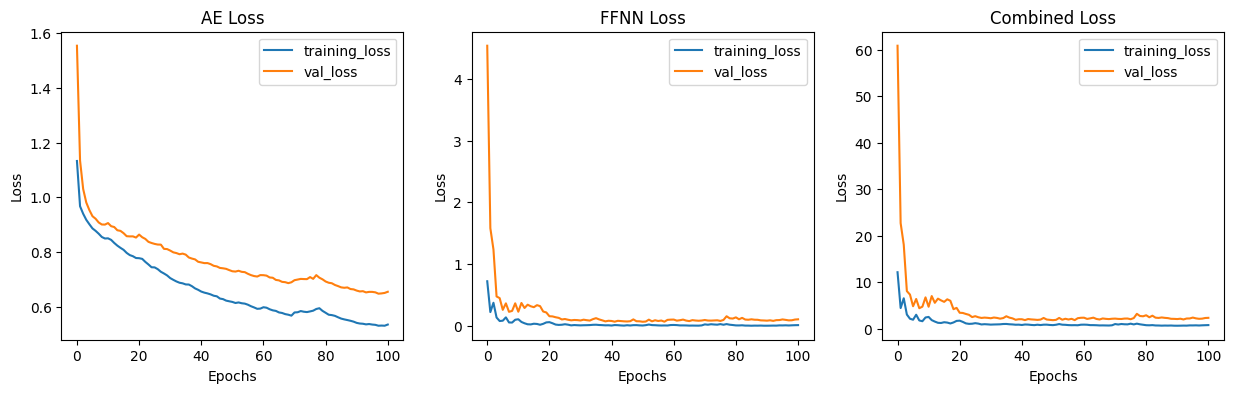

In [122]:
fig,ax = plt.subplots(1,3, figsize = (15,4))
title_best = ['AE Loss', 'FFNN Loss', 'Combined Loss']
keys_best = list(history_best.history.keys())
key_pairs_best = [(keys_best[i], keys_best[i+3]) for i in range(3)]

for i in range(3):
    ax[i].plot(history_best.history[key_pairs_best[i][0]], label='training_loss')
    ax[i].plot(history_best.history[key_pairs_best[i][1]], label='val_loss')

    ax[i].set_title(title_best[i])
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


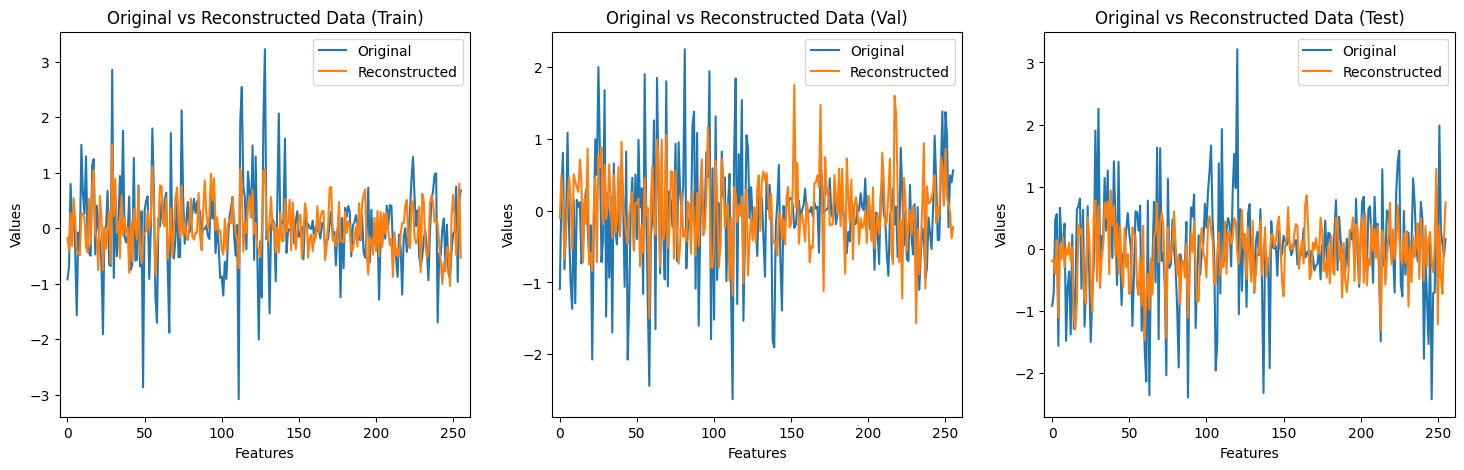

In [123]:
reconstructed_X_train_best = autoencoder.predict(X_train)
reconstructed_X_val_best = autoencoder.predict(X_val)
reconstructed_X_test_best = autoencoder.predict(X_test)

sample_idx_train_best = X_train[0]
sample_idx_val_best = X_val[0]
sample_idx_test_best = X_test[0]

fig, ax = plt.subplots(1,3, figsize = (18,5))

ax[0].plot(X_train[0], label = 'Original')
ax[1].plot(X_val[0], label = 'Original')
ax[2].plot(X_test[0], label = 'Original')

ax[0].plot(reconstructed_X_train_best[0], label = 'Reconstructed')
ax[1].plot(reconstructed_X_val_best[0], label = 'Reconstructed')
ax[2].plot(reconstructed_X_test_best[0], label = 'Reconstructed')

ax[0].set_xlabel('Features')
ax[0].set_ylabel('Values')

ax[1].set_xlabel('Features')
ax[1].set_ylabel('Values')

ax[2].set_xlabel('Features')
ax[2].set_ylabel('Values')

ax[0].set_title('Original vs Reconstructed Data (Train)')
ax[1].set_title('Original vs Reconstructed Data (Val)')
ax[2].set_title('Original vs Reconstructed Data (Test)')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_xlim([-5, X.shape[1]+5])
ax[1].set_xlim([-5, X.shape[1]+5])
ax[2].set_xlim([-5, X.shape[1]+5])

plt.show()

In [124]:
import numpy as np
from sklearn import metrics

# Predictions
pred_train_best = combined_model.predict(X_train)
pred_val_best = combined_model.predict(X_val)
pred_test_best = combined_model.predict(X_test)

# Ensure predictions do not contain NaNs
pred_train_best = [np.nan_to_num(pred) for pred in pred_train_best]
pred_val_best = [np.nan_to_num(pred) for pred in pred_val_best]
pred_test_best = [np.nan_to_num(pred) for pred in pred_test_best]

# Ensure y values do not contain NaNs
y_train = np.nan_to_num(y_train)
y_val = np.nan_to_num(y_val)
y_test = np.nan_to_num(y_test)

# Masks
mask_train_labeled = ~np.equal(y_train, 0).any(axis=1)
mask_val_labeled = ~np.equal(y_val, 0).any(axis=1)
mask_test_labeled = ~np.equal(y_test, 0).any(axis=1)

# Compute evaluation metrics for the labeled training data
r2_train_ef_best = metrics.r2_score(y_train[mask_train_labeled][:, 0], pred_train_best[1][mask_train_labeled][:, 0])
r2_train_mu_best = metrics.r2_score(y_train[mask_train_labeled][:, 1], pred_train_best[1][mask_train_labeled][:, 1])

mae_train_ef_best = metrics.mean_absolute_error(y_train[mask_train_labeled][:, 0], pred_train_best[1][mask_train_labeled][:, 0])
mae_train_mu_best = metrics.mean_absolute_error(y_train[mask_train_labeled][:, 1], pred_train_best[1][mask_train_labeled][:, 1])

# Compute evaluation metrics for the labeled validation data
r2_val_ef_best = metrics.r2_score(y_val[mask_val_labeled][:, 0], pred_val_best[1][mask_val_labeled][:, 0])
r2_val_mu_best = metrics.r2_score(y_val[mask_val_labeled][:, 1], pred_val_best[1][mask_val_labeled][:, 1])

mae_val_ef_best = metrics.mean_absolute_error(y_val[mask_val_labeled][:, 0], pred_val_best[1][mask_val_labeled][:, 0])
mae_val_mu_best = metrics.mean_absolute_error(y_val[mask_val_labeled][:, 1], pred_val_best[1][mask_val_labeled][:, 1])

# Compute evaluation metrics for the labeled test data
r2_test_ef_best = metrics.r2_score(y_test[mask_test_labeled][:, 0], pred_test_best[1][mask_test_labeled][:, 0])
r2_test_mu_best = metrics.r2_score(y_test[mask_test_labeled][:, 1], pred_test_best[1][mask_test_labeled][:, 1])

mae_test_ef_best = metrics.mean_absolute_error(y_test[mask_test_labeled][:, 0], pred_test_best[1][mask_test_labeled][:, 0])
mae_test_mu_best = metrics.mean_absolute_error(y_test[mask_test_labeled][:, 1], pred_test_best[1][mask_test_labeled][:, 1])

width = 10
print(f'{"Properties":>{width+1}} {"R2(Train)":>{width+1}} {"R2(Val)":>{width-1}} {"R2(Test)":>{width}} {"MAE(Train)":>{width+2}} {"MAE(Val)":>{width}} {"MAE(Test)":>{width}}')
print('='*80)
print(f'{"Ef":>{width}} {r2_train_ef_best:>{width}.3f} {r2_val_ef_best:>{width}.3f} {r2_test_ef_best:>{width}.3f} {mae_train_ef_best:>{width}.3f} {mae_val_ef_best:>{width}.3f} {mae_test_ef_best:>{width}.3f}')
print(f'{"Mu":>{width}} {r2_train_mu_best:>{width}.3f} {r2_val_mu_best:>{width}.3f} {r2_test_mu_best:>{width}.3f} {mae_train_mu_best:>{width}.3f} {mae_val_mu_best:>{width}.3f} {mae_test_mu_best:>{width}.3f}')

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 Properties   R2(Train)   R2(Val)   R2(Test)   MAE(Train)   MAE(Val)  MAE(Test)
        Ef      0.972      0.717      0.830      0.148      0.356      0.378
        Mu      0.978      0.692      0.739      0.094      0.316      0.274


In [131]:
# fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (15,7))
# ax1.scatter(y_train[mask_train_labeled][:, 0], pred_train_best[1][mask_train_labeled][:, 0], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
# ax1.scatter(y_val[mask_val_labeled][:, 0], pred_val_best[1][mask_val_labeled][:, 0], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
# ax1.scatter(y_test[mask_test_labeled][:, 0], pred_test_best[1][mask_test_labeled][:, 0], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
# ax1.plot([-4.5, 3], [-4.5, 3])

# ax2.scatter(y_train[mask_train_labeled][:, 1], pred_train_best[1][mask_train_labeled][:, 1], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
# ax2.scatter(y_val[mask_val_labeled][:, 1], pred_val_best[1][mask_val_labeled][:, 1], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
# ax2.scatter(y_test[mask_test_labeled][:, 1], pred_test_best[1][mask_test_labeled][:, 1], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
# ax2.plot([0, 5], [0, 5])

# ax1.set_title('Ef: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(r2_train_ef_best, r2_val_ef, r2_test_ef_best))
# ax2.set_title('Mu: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(r2_train_mu_best, r2_val_mu, r2_test_mu_best))

# ax1.set_xlabel('DFT Ef')
# ax1.set_ylabel('Predicted Ef')

# ax2.set_xlabel('DFT Mu')
# ax2.set_ylabel('Predicted Mu')

# ax1.set_xlim([-4.5, 3])
# ax1.set_ylim([-4.5, 3])

# ax2.set_xlim([1, 5])
# ax2.set_ylim([1, 5])

# ax1.legend()
# ax2.legend()

# plt.show()

# #plt.savefig("r2s.png", dpi=300)

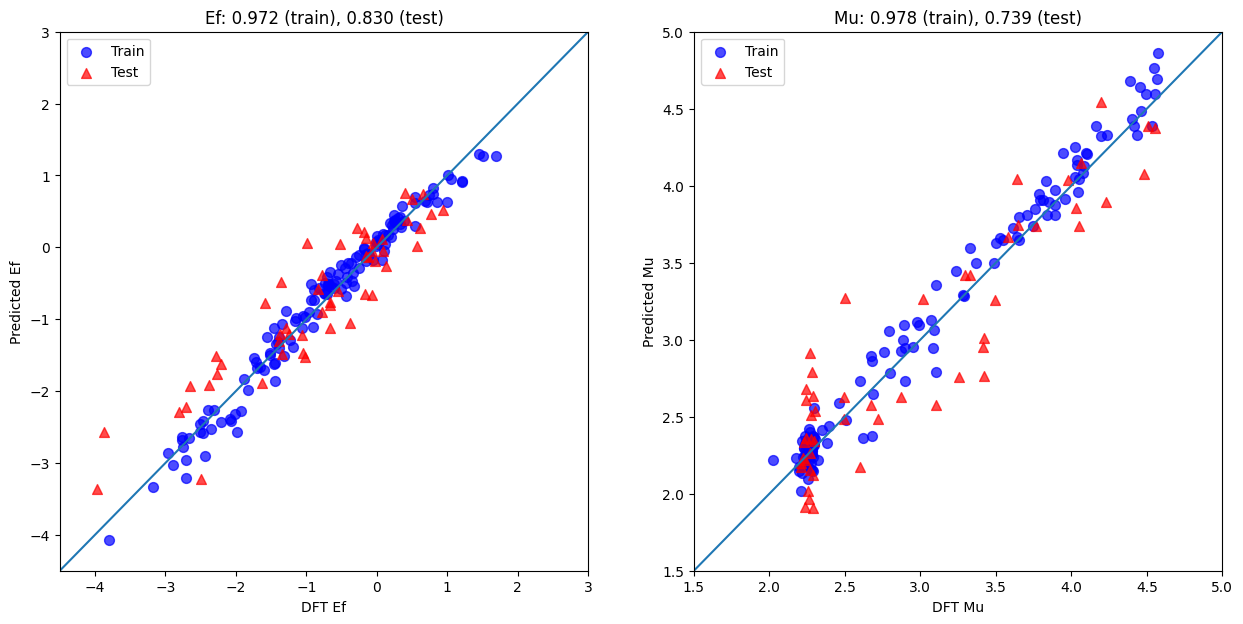

In [130]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (15,7))
ax1.scatter(y_train[mask_train_labeled][:, 0], pred_train_best[1][mask_train_labeled][:, 0], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
#ax1.scatter(y_val[mask_val_labeled][:, 0], pred_val_best[1][mask_val_labeled][:, 0], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax1.scatter(y_test[mask_test_labeled][:, 0], pred_test_best[1][mask_test_labeled][:, 0], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax1.plot([-4.5, 3], [-4.5, 3])

ax2.scatter(y_train[mask_train_labeled][:, 1], pred_train_best[1][mask_train_labeled][:, 1], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
#ax2.scatter(y_val[mask_val_labeled][:, 1], pred_val_best[1][mask_val_labeled][:, 1], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax2.scatter(y_test[mask_test_labeled][:, 1], pred_test_best[1][mask_test_labeled][:, 1], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax2.plot([0, 5], [0, 5])

ax1.set_title('Ef: {:.3f} (train), {:.3f} (test)'.format(r2_train_ef_best, r2_test_ef_best))
ax2.set_title('Mu: {:.3f} (train), {:.3f} (test)'.format(r2_train_mu_best, r2_test_mu_best))

ax1.set_xlabel('DFT Ef')
ax1.set_ylabel('Predicted Ef')

ax2.set_xlabel('DFT Mu')
ax2.set_ylabel('Predicted Mu')

ax1.set_xlim([-4.5, 3])
ax1.set_ylim([-4.5, 3])

ax2.set_xlim([1.5, 5])
ax2.set_ylim([1.5, 5])

ax1.legend()
ax2.legend()

plt.show()

#plt.savefig("r2s.png", dpi=300)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


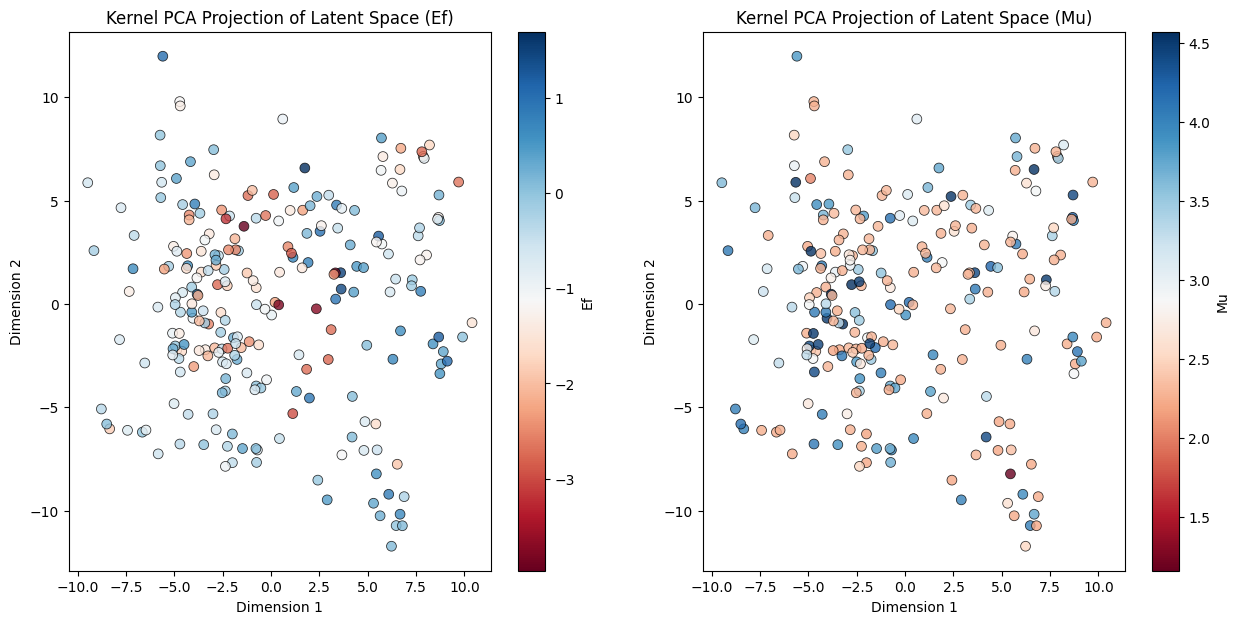

In [127]:
# Extract latent representations
encoder_model_best = Model(inputs = encoder_input, outputs = encoder_output)
latent_X_best = encoder_model.predict(X[:240,:])

# Apply Kernel PCA
kpca_best = KernelPCA(n_components=2, kernel='linear', gamma=None, fit_inverse_transform=True, alpha=1.0, n_jobs=-1)
kpca_embeddings_best = kpca_best.fit_transform(latent_X_best)

# Create a DataFrame for Seaborn
kpca_df_best = pd.DataFrame(data={'Dimension 1': kpca_embeddings_best[:, 0],
                             'Dimension 2': kpca_embeddings_best[:, 1],
                             'Ef': y['Ef_per_cell'],
                             'Mu': y['Mu_per_cell']})

# Visualize the projected latent space using Seaborn
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
scatter_best_ef = sns.scatterplot(ax=ax[0], data=kpca_df_best, x='Dimension 1', y='Dimension 2', hue='Ef', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)
scatter_best_mu = sns.scatterplot(ax=ax[1], data=kpca_df_best, x='Dimension 1', y='Dimension 2', hue='Mu', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)

norm_best_ef = Normalize(vmin=kpca_df_best['Ef'].min(), vmax=kpca_df_best['Ef'].max())
norm_best_mu = Normalize(vmin=kpca_df_best['Mu'].min(), vmax=kpca_df_best['Mu'].max())

sm_best_ef = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_best_ef)
sm_best_mu = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_best_mu)

sm_best_ef.set_array([])
sm_best_mu.set_array([])

cbar_best_ef = fig.colorbar(sm_best_ef, ax=ax[0])
cbar_best_mu = fig.colorbar(sm_best_mu, ax=ax[1])

cbar_best_ef.set_label('Ef')
cbar_best_mu.set_label('Mu')

ax[0].set_title('Kernel PCA Projection of Latent Space (Ef)')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')

ax[1].set_title('Kernel PCA Projection of Latent Space (Mu)')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')

plt.show()